In [1]:
# Imports 
import numpy as np
from numpy import *
from scipy.special import erf
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from scipy.special import factorial2 as fact2
import itertools
import time

In [2]:
# Molecule definition

molecule = 'H2'

# Number of atoms
Nat = 2
# Atomic valencies
Z = [1, 1]
# Number of electrons
Nelec = 2

basis = 'cc-pVDZ'

In [3]:
# Calculation setup

# SCF solver parameters
level_shift = 0.0
damp_p = 2/3
maxit_scf = 500
tol_scf = 10**-6
diis_size_scf = 3

# CC Solver parameters
maxit_cc = 100
tol_cc = 10**-6 
diis_size_cc = 5

# EOM-CC Solver parameters
# Tune number of vectors per state and thresh_vec to prevent eigenvalue collapse to 0
maxit_eom = 30
tol_eom = 10**-5
nstates = 5
nvec_per_state = 2
max_nvec = 1000
thresh_vec = 10**-9
flag_eom_verbose = True
flag_cis_guess = False # seems to make things worse...

# Molecular geometries
num_pts = 80
atom_coordinates = []
RJ = np.linspace(0.7,4,num_pts)
#RJ = np.array([1.4])
#RJ = np.array([5])
HOH_angle = np.radians([104.5])

for J in range(num_pts):

    if molecule== 'H2O':
        theta = 0.5*(pi - HOH_angle)
        atom_coordinates.append( [[RJ[J]*np.cos(theta), RJ[J]*np.sin(theta), 0],
                                 [-RJ[J]*np.cos(theta), RJ[J]*np.sin(theta), 0],
                                 [0, 0, 0]] )
    if molecule == 'H2':
        atom_coordinates.append( [[0, 0, -RJ[J]/2],
                                  [0, 0, RJ[J]/2]] )


In [4]:
class BasisFunction:
    ''' A class that contains all our basis function data
            Attributes:
            origin: array/list containing the coordinates of the Gaussian origin
            shell:  tuple of angular momentum
            exps:   list of primitive Gaussian exponents
            coefs:  list of primitive Gaussian coefficients
            norm:   list of normalization factors for Gaussian primitives
    '''
    def __init__(self,origin=[0.0,0.0,0.0],shell=(0,0,0),exps=[],coefs=[]): 
        self.origin = np.asarray(origin)
        self.shell = shell
        self.exps = exps
        self.coefs = coefs
        self.norm = None
        self.normalize()
        
    def normalize(self):
        ''' Routine to normalize the basis functions, in case they
                    do not integrate to unity.
                '''
        l,m,n = self.shell
        L = l+m+n
        # self.norm is a list of length equal to number primitives 
        # normalize primitives first (PGBFs)
        self.norm = np.sqrt(np.power(2,2*(l+m+n)+1.5)*\
                            np.power(self.exps,l+m+n+1.5)/fact2(2*l-1)/fact2(2*m-1)/fact2(2*n-1)/np.power(np.pi,1.5))
        # now normalize the contracted basis functions (CGBFs) # Eq. 1.44 of Valeev integral whitepaper
        prefactor = np.power(np.pi,1.5)*\
                fact2(2*l - 1)*fact2(2*m - 1)*fact2(2*n - 1)/np.power(2.0,L)
        N = 0.0
        num_exps = len(self.exps) 
        for ia in range(num_exps):
            for ib in range(num_exps):
                N += self.norm[ia]*self.norm[ib]*self.coefs[ia]*self.coefs[ib]/np.power(self.exps[ia] + self.exps[ib],L+1.5)
        N *= prefactor
        N = np.power(N,-0.5)
        for ia in range(num_exps):
            self.coefs[ia] *= N
            
    def basisfcn_matrix(self,xdom,ydom,zdom):
        ''' Method that returns a 3-dimensional matrix corresponding to the 
            3D basis function evaluated in space on over a domain (xdom,ydom,zdom)
        '''
        l,m,n = self.shell
        xi = self.exps  
        G = np.zeros((len(xdom),len(ydom),len(zdom)))
        for i in range(len(xi)):
            gauss_x = xdom**l*np.exp(-xi[i]*xdom**2)
            gauss_y = ydom**m*np.exp(-xi[i]*ydom**2)
            gauss_z = zdom**n*np.exp(-xi[i]*zdom**2)
            Temp = np.kron(gauss_z,np.kron(gauss_y,gauss_x))
            G += self.coefs[i]*np.reshape(Temp,[len(xdom),len(ydom),len(zdom)])
            
        return G
            
            
            

In [5]:
def E(i,j,t,Qx,a,b):
    ''' Recursive definition of Hermite Gaussian coefficients.
            Returns a float.
            a: orbital exponent on Gaussian 'a' (e.g. alpha in the text)
            b: orbital exponent on Gaussian 'b' (e.g. beta in the text)
            i,j: orbital angular momentum number on Gaussian 'a' and 'b'
            t: number nodes in Hermite (depends on type of integral,
               e.g. always zero for overlap integrals)
            Qx: distance between origins of Gaussian 'a' and 'b'
    '''
    p=a+b
    q = a*b/p
    if (t < 0) or (t > (i + j)): # out of bounds for t
        return 0.0
    elif i == j == t == 0: # base case
        return np.exp(-q*Qx*Qx) # K_AB 
    elif j == 0: # decrement index i
        return (1/(2*p))*E(i-1,j,t-1,Qx,a,b) -  (q*Qx/a)*E(i-1,j,t,Qx,a,b) +  (t+1)*E(i-1,j,t+1,Qx,a,b)
    else: # decrement index j
        return (1/(2*p))*E(i,j-1,t-1,Qx,a,b) +  (q*Qx/b)*E(i,j-1,t,Qx,a,b) +  (t+1)*E(i,j-1,t+1,Qx,a,b)
            
def overlap(a,lmn1,A,b,lmn2,B):
    ''' Evaluates overlap integral between two Gaussians
            Returns a float.
            a:    orbital exponent on Gaussian 'a' (e.g. alpha in the text)
            b:    orbital exponent on Gaussian 'b' (e.g. beta in the text)
            lmn1: int tuple containing orbital angular momentum (e.g. (1,0,0))
                  for Gaussian 'a'
            lmn2: int tuple containing orbital angular momentum for Gaussian 'b'
            A:    list containing origin of Gaussian 'a', e.g. [1.0, 2.0, 0.0]
            B:    list containing origin of Gaussian 'b'
    '''
    l1,m1,n1 = lmn1 # shell angular momentum on Gaussian 'a' 
    l2,m2,n2 = lmn2 # shell angular momentum on Gaussian 'b' 
    S1 = E(l1,l2,0,A[0]-B[0],a,b) # X
    S2 = E(m1,m2,0,A[1]-B[1],a,b) # Y
    S3 = E(n1,n2,0,A[2]-B[2],a,b) # Z
    return S1*S2*S3*np.power(np.pi/(a+b),1.5)

def kinetic(a,lmn1,A,b,lmn2,B):
    ''' Evaluates kinetic energy integral between two Gaussians
            Returns a float.
            a:    orbital exponent on Gaussian 'a' (e.g. alpha in the text)
            b:    orbital exponent on Gaussian 'b' (e.g. beta in the text)
            lmn1: int tuple containing orbital angular momentum (e.g. (1,0,0))
                  for Gaussian 'a'
            lmn2: int tuple containing orbital angular momentum for Gaussian 'b'
            A:    list containing origin of Gaussian 'a', e.g. [1.0, 2.0, 0.0]
            B:    list containing origin of Gaussian 'b'
    '''
    
    l1,m1,n1 = lmn1
    l2,m2,n2 = lmn2
    
    term0 = b*(2*(l2+m2+n2)+3)*overlap(a,(l1,m1,n1),A,b,(l2,m2,n2),B)
    
    term1 = -2*np.power(b,2)*(overlap(a,(l1,m1,n1),A,b,(l2+2,m2,n2),B) +
                            overlap(a,(l1,m1,n1),A,b,(l2,m2+2,n2),B) +
                            overlap(a,(l1,m1,n1),A,b,(l2,m2,n2+2),B))
    
    term2 = -0.5*(l2*(l2-1)*overlap(a,(l1,m1,n1),A,b,(l2-2,m2,n2),B) +
                  m2*(m2-1)*overlap(a,(l1,m1,n1),A,b,(l2,m2-2,n2),B) +
                  n2*(n2-1)*overlap(a,(l1,m1,n1),A,b,(l2,m2,n2-2),B)) 
    
    return term0+term1+term2

def R(t,u,v,n,p,PCx,PCy,PCz,RPC):
    ''' Returns the Coulomb auxiliary Hermite integrals
            Returns a float.
            Arguments:
            t,u,v:   order of Coulomb Hermite derivative in x,y,z
                     (see defs in Helgaker and Taylor)
            n:       order of Boys function
            PCx,y,z: Cartesian vector distance between Gaussian
                     composite center P and nuclear center C
            RPC:     Distance between P and C
    '''
    T = p*RPC*RPC
    val = 0.0
    if t == u == v == 0:
        val += np.power(-2*p,n)*boys(n,T) 
    elif t == u == 0:
        if v > 1:
            val += (v-1)*R(t,u,v-2,n+1,p,PCx,PCy,PCz,RPC)
        val += PCz*R(t,u,v-1,n+1,p,PCx,PCy,PCz,RPC) 
    elif t == 0:
        if u > 1:
            val += (u-1)*R(t,u-2,v,n+1,p,PCx,PCy,PCz,RPC)
        val += PCy*R(t,u-1,v,n+1,p,PCx,PCy,PCz,RPC) 
    else:
        if t > 1:
            val += (t-1)*R(t-2,u,v,n+1,p,PCx,PCy,PCz,RPC)
        val += PCx*R(t-1,u,v,n+1,p,PCx,PCy,PCz,RPC) 
    return val

from scipy.special import hyp1f1
def boys(n,T):
    return hyp1f1(n+0.5,n+1.5,-T)/(2.0*n+1.0)

def gaussian_product_center(a,A,b,B): 
    return (a*A+b*B)/(a+b)

def nuclear_attraction(a,lmn1,A,b,lmn2,B,C):
    ''' Evaluates kinetic energy integral between two Gaussians
             Returns a float.
             a:    orbital exponent on Gaussian 'a' (e.g. alpha in the text)
             b:    orbital exponent on Gaussian 'b' (e.g. beta in the text)
             lmn1: int tuple containing orbital angular momentum (e.g. (1,0,0))
                   for Gaussian 'a'
             lmn2: int tuple containing orbital angular momentum for Gaussian 'b'
             A:    list containing origin of Gaussian 'a', e.g. [1.0, 2.0, 0.0]
             B:    list containing origin of Gaussian 'b'
             C:    list containing origin of nuclear center 'C'
    '''
    l1,m1,n1 = lmn1
    l2,m2,n2 = lmn2
    p=a+b
    P = gaussian_product_center(a,A,b,B) # Gaussian composite center 
    RPC = np.linalg.norm(P-C)
    val = 0.0
    for t in range(l1+l2+1):
        for u in range(m1+m2+1):
            for v in range(n1+n2+1):
                 val += E(l1,l2,t,A[0]-B[0],a,b) * E(m1,m2,u,A[1]-B[1],a,b) * E(n1,n2,v,A[2]-B[2],a,b) * \
                    R(t,u,v,0,p,P[0]-C[0],P[1]-C[1],P[2]-C[2],RPC)
    val *= 2*np.pi/p 
    return val

def electron_repulsion(a,lmn1,A,b,lmn2,B,c,lmn3,C,d,lmn4,D): 
    ''' Evaluates kinetic energy integral between two Gaussians
         Returns a float.
         a,b,c,d:   orbital exponent on Gaussian 'a','b','c','d'
         lmn1,lmn2
         lmn3,lmn4: int tuple containing orbital angular momentum
                    for Gaussian 'a','b','c','d', respectively
         A,B,C,D:   list containing origin of Gaussian 'a','b','c','d'
    '''
    l1,m1,n1 = lmn1
    l2,m2,n2 = lmn2
    l3,m3,n3 = lmn3
    l4,m4,n4 = lmn4
    p = a+b # composite exponent for P (from Gaussians 'a' and 'b') 
    q = c+d # composite exponent for Q (from Gaussians 'c' and 'd') 
    alpha = p*q/(p+q)
    P = gaussian_product_center(a,A,b,B) # A and B composite center 
    Q = gaussian_product_center(c,C,d,D) # C and D composite center 
    RPQ = np.linalg.norm(P-Q)
    val = 0.0
    for t in range(l1+l2+1):
        for u in range(m1+m2+1):
            for v in range(n1+n2+1):
                for tau in range(l3+l4+1): 
                    for nu in range(m3+m4+1):
                        for phi in range(n3+n4+1):
                            val += E(l1,l2,t,A[0]-B[0],a,b) * \
                                    E(m1,m2,u,A[1]-B[1],a,b) * \
                                    E(n1,n2,v,A[2]-B[2],a,b) * \
                                    E(l3,l4,tau,C[0]-D[0],c,d) * \
                                    E(m3,m4,nu ,C[1]-D[1],c,d) * \
                                    E(n3,n4,phi,C[2]-D[2],c,d) * \
                                    np.power(-1,tau+nu+phi) * \
                                    R(t+tau,u+nu,v+phi,0,\
                                        alpha,P[0]-Q[0],P[1]-Q[1],P[2]-Q[2],RPQ)
    val *= 2*np.power(np.pi,2.5)/(p*q*np.sqrt(p+q)) 
    return val

In [6]:
def S(a,b):
    '''Evaluates overlap between two contracted Gaussians
           Returns float.
           Arguments:
           a: contracted Gaussian 'a', BasisFunction object
           b: contracted Gaussian 'b', BasisFunction object
    '''
    s = 0.0
    for ia, ca in enumerate(a.coefs):
        for ib, cb in enumerate(b.coefs):
            s += a.norm[ia]*b.norm[ib]*ca*cb*\
                 overlap(a.exps[ia],a.shell,a.origin,
                 b.exps[ib],b.shell,b.origin)
    return s

def T(a,b):
    '''Evaluates kinetic energy between two contracted Gaussians
           Returns float.
           Arguments:
           a: contracted Gaussian 'a', BasisFunction object
           b: contracted Gaussian 'b', BasisFunction object
    '''
    t = 0.0
    for ia, ca in enumerate(a.coefs):
        for ib, cb in enumerate(b.coefs):
            t += a.norm[ia]*b.norm[ib]*ca*cb*kinetic(a.exps[ia],a.shell,a.origin,b.exps[ib],b.shell,b.origin)
    return t

def V(a,b,C,Z):
    '''Evaluates overlap between two contracted Gaussians
            Returns float.
            Arguments:
            a: contracted Gaussian 'a', BasisFunction object
            b: contracted Gaussian 'b', BasisFunction object
            C: center of nucleus
    '''
    v = 0.0
    for ia, ca in enumerate(a.coefs):
        for ib, cb in enumerate(b.coefs):
            v += a.norm[ia]*b.norm[ib]*ca*cb*nuclear_attraction(a.exps[ia],a.shell,a.origin,b.exps[ib],b.shell,b.origin,C)
    return -v*Z

def ERI(a,b,c,d):
    '''Evaluates overlap between two contracted Gaussians
            Returns float.
            Arguments:
            a: contracted Gaussian 'a', BasisFunction object
            b: contracted Gaussian 'b', BasisFunction object
            c: contracted Gaussian 'b', BasisFunction object
            d: contracted Gaussian 'b', BasisFunction object
    '''
    eri = 0.0
    for ja, ca in enumerate(a.coefs):
        for jb, cb in enumerate(b.coefs):
            for jc, cc in enumerate(c.coefs):
                for jd, cd in enumerate(d.coefs):
                    eri += a.norm[ja]*b.norm[jb]*c.norm[jc]*d.norm[jd]*\
                           ca*cb*cc*cd*\
                           electron_repulsion(a.exps[ja],a.shell,a.origin,\
                                b.exps[jb],b.shell,b.origin,\
                                c.exps[jc],c.shell,c.origin,\
                                d.exps[jd],d.shell,d.origin)
    return eri

In [7]:
#### General Functions ####

def construct_orbitals(SHELL, XI, CM, atom_coordinates):
    orbs = []; Nat = len(SHELL);
    for i in range(Nat):
        for j in range(len(XI[i])):
            orbs.append(BasisFunction(origin=atom_coordinates[i][:],shell=SHELL[i][j],exps=XI[i][j],coefs=CM[i][j]))
    return orbs

def ao_to_mo(AO,C):
    if len(AO.shape) == 2:
        T1 = np.einsum('jb,ij->ib',C,AO,optimize=True)
        T2 = np.einsum('ia,ib->ab',C,T1,optimize=True)
        return T2
    else:
        T1 = np.einsum('ld,ijkl->ijkd',C,AO,optimize=True)
        T2 = np.einsum('kc,ijkd->ijcd',C,T1,optimize=True)
        T3 = np.einsum('jb,ijcd->ibcd',C,T2,optimize=True)
        T4 = np.einsum('ia,ibcd->abcd',C,T3,optimize=True)
        return T4

def spatial_to_spinorb(MO):
    Norb = MO.shape[0]
    if len(MO.shape) == 2:
        MO_sp = np.zeros((2*Norb,2*Norb))
        for i in range(2*Norb):
            for j in range(2*Norb):
                if i%2 == j%2:    
                    i0 = int(np.floor(i/2))
                    j0 = int(np.floor(j/2))
                    MO_sp[i,j] = MO[i0,j0]
            
    else:
        MO_sp = np.zeros((2*Norb,2*Norb,2*Norb,2*Norb))
        for i in range(2*Norb):
            for j in range(2*Norb):
                for k in range(2*Norb):
                    for l in range(2*Norb):
                        if i%2 == k%2 and j%2 == l%2:
                            i0 = int(np.floor(i/2))
                            j0 = int(np.floor(j/2))
                            k0 = int(np.floor(k/2))
                            l0 = int(np.floor(l/2))
                            MO_sp[i,j,k,l] = MO[i0,j0,k0,l0]
    return MO_sp
                
def diis_pulay_solver(X_list,diis_resid_list):
        B_dim = len(X_list) + 1
        B = np.empty((B_dim, B_dim))
        B[-1, :] = -1
        B[:, -1] = -1
        B[-1, -1] = 0
        for i in range(len(X_list)):
            for j in range(i,len(X_list)):
                B[i, j] = np.einsum('ij,ij->', diis_resid_list[i], diis_resid_list[j], optimize=True)
                B[j, i] = B[i, j]

        # Build RHS of Pulay equation 
        rhs = np.zeros((B_dim))
        rhs[-1] = -1

        # Solve Pulay equation for c_i's 
        if np.linalg.det(B) != 0:
            coeff = np.linalg.solve(B, rhs)
            # Build DIIS Fock matrix 
            X = np.zeros_like(X_list[0])
            for x in range(B_dim - 1):
                X += coeff[x] * X_list[x]
            return X
        else:
            return X_list[-1]

In [8]:
#### SCF Functions ####

def calculate_onebody_ints(orbs,atom_coordinates):
    # Number of spatial orbitals
    Norb = len(orbs)
    # Allocate 
    Smat = np.zeros((Norb,Norb))
    Tmat = np.zeros((Norb,Norb))
    Vmat = np.zeros((Norb,Norb))
    # Calculate onebody integrals
    for i in range(Norb):
        for j in range(i,Norb):
            Smat[i,j] = S(orbs[i],orbs[j])
            Tmat[i,j] = T(orbs[i],orbs[j])
            for k in range(Nat):
                Vmat[i,j] += V(orbs[i],orbs[j],atom_coordinates[k][:],Z[k])
            Smat[j,i] = Smat[i,j]
            Tmat[j,i] = Tmat[i,j]
            Vmat[j,i] = Vmat[i,j]
    return Smat,Tmat,Vmat

def calculate_twobody_ints(orbs,vec):
    
    Norb = len(orbs)
    VVmat = np.zeros((Norb,Norb,Norb,Norb))
    
    if vec: # slower?
        num_twobody = int(Norb*(Norb+1)*(Norb**2+Norb+2)/8)
        VVmatvec = np.zeros(num_twobody)
        # Calculate only permutationally unique twobody integrals
        ct = 0
        for i in range(Norb):
            for j in range(i+1):
                for k in range(i+1):
                    if i == k: 
                        lmax = j+1 
                    else: 
                        lmax = k+1
                    for l in range(lmax):
                        VVmatvec[ct] = ERI(orbs[i],orbs[j],orbs[k],orbs[l]) # chemist notation
                        ct += 1
        # Insert unique integrals into 4-dimensional array
        for i in range(Norb):
            for j in range(Norb):
                if i > j: 
                    ij = i*(i+1)/2+j 
                else: 
                    ij = j*(j+1)/2 + i
                for k in range(Norb):
                    for l in range(Norb):
                        if k > l: 
                            kl = k*(k+1)/2+l 
                        else: 
                            kl = l*(l+1)/2 + k
                        if ij > kl: 
                            ijkl = ij*(ij+1)/2 + kl 
                        else: 
                            ijkl = kl*(kl+1)/2 + ij       
                        VVmat[i,k,j,l] = VVmatvec[int(ijkl)] # physics notation
        return VVmat,VVmatvec
    else:
        # Calculate twobody integrals
        for i in range(Norb):
            for j in range(i+1):
                ij = i*(i+1)/2 + j
                for k in range(Norb):
                    for l in range(k+1):
                        kl = k*(k+1)//2 + l
                        if ij >= kl:
                            val = ERI(orbs[i],orbs[j],orbs[k],orbs[l])
                            VVmat[i,k,j,l] = val
                            VVmat[j,k,i,l] = val
                            VVmat[i,l,j,k] = val
                            VVmat[k,i,l,j] = val
                            VVmat[l,i,k,j] = val
                            VVmat[l,j,k,i] = val
                            VVmat[j,l,i,k] = val
                            VVmat[k,j,l,i] = val
        return VVmat

def calc_nuclear_nuclear(atom_coordinates,Z):
    Vnn = 0.0
    Nat = len(atom_coordinates)
    for i in range(Nat):
        for j in range(Nat):
            if i != j:
                Ri = np.asarray(atom_coordinates[i][:])
                Rj = np.asarray(atom_coordinates[j][:])
                Vnn += Z[i]*Z[j]/np.linalg.norm(Ri-Rj)
    return Vnn/2

def orthomat(S,tol,kind):
    evalS, U = np.linalg.eigh(S)
    diagS_minushalf = np.diag(evalS**(-0.5))
    if kind == 'symmetric':
        X0 = np.dot(U,np.dot(diagS_minushalf,U.T))
    else:
        X0 = np.dot(U,diagS_minushalf)
        
    idX = [i for i in range(S.shape[0])]
    for i in range(S.shape[0]):
        for j in range(i+1,S.shape[0]):
            if np.abs(evalS[i]-evalS[j]) < tol:
                J = idX.index(j)
                idX.remove(J)
    X = X0[:,idX]
    return X

In [9]:
#### CCSD Functions ####

def cc_energy(t1,t2,VM,FM,Nocc):
    Ecc = np.einsum('ia,ai->',FM[:Nocc,Nocc:],t1,optimize=True) +\
          0.25*np.einsum('ijab,abij->',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) +\
          0.5*np.einsum('jb,bj->',np.einsum('ijab,ai->jb',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True),t1,optimize=True)
    return Ecc
                
def t1_fcn(t1,t2,VM,FM,Nocc,Nunocc):
    
    # Fock masks to zero diagonal
    Zocc = np.ones((Nocc,Nocc)) - np.eye(Nocc)
    Zunocc = np.ones((Nunocc,Nunocc)) - np.eye(Nunocc)
    
    # Intermediates
    chi_me = FM[:Nocc,Nocc:] + np.einsum('mnef,fn->me',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chi_mi = FM[:Nocc,:Nocc]*Zocc + \
             np.einsum('mnif,fn->mi',VM[:Nocc,:Nocc,:Nocc,Nocc:],t1,optimize=True)+ \
             0.5*np.einsum('mnef,efin->mi',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True)
    
    chi_ae = FM[Nocc:,Nocc:]*Zunocc + \
             np.einsum('anef,fn->ae',VM[Nocc:,:Nocc,Nocc:,Nocc:],t1,optimize=True) - \
             0.5*np.einsum('mnef,afmn->ae',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) - \
             np.einsum('me,am->ae',chi_me,t1,optimize=True)
    
    TEMP1 = FM[Nocc:,:Nocc] + \
            np.einsum('me,aeim->ai',chi_me,t2,optimize=True) - \
            np.einsum('maie,em->ai',VM[:Nocc,Nocc:,:Nocc,Nocc:],t1,optimize=True) -\
            np.einsum('mi,am->ai',chi_mi,t1,optimize=True) + \
            np.einsum('ae,ei->ai',chi_ae,t1,optimize=True) - \
            0.5*np.einsum('mnif,afmn->ai',VM[:Nocc,:Nocc,:Nocc,Nocc:],t2,optimize=True) + \
            0.5*np.einsum('anef,efin->ai',VM[Nocc:,:Nocc,Nocc:,Nocc:],t2,optimize=True)
    

    return TEMP1

def t2_fcn(t1,t2,VM,FM,Nocc,Nunocc):
    
    # Fock masks to zero diagonal
    Zocc = np.ones((Nocc,Nocc)) - np.eye(Nocc)
    Zunocc = np.ones((Nunocc,Nunocc)) - np.eye(Nunocc)
    
    # Intermediates    
    chi_mi = FM[:Nocc,:Nocc]*Zocc + \
             np.einsum('mnif,fn->mi',VM[:Nocc,:Nocc,:Nocc,Nocc:],t1,optimize=True)+ \
             np.einsum('mnef,efin->mi',0.5*VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True)
    
    chi_me = FM[:Nocc,Nocc:] + np.einsum('mnef,fn->me',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chi_ae = FM[Nocc:,Nocc:]*Zunocc + \
             np.einsum('anef,fn->ae',VM[Nocc:,:Nocc,Nocc:,Nocc:],t1,optimize=True) - \
             0.5*np.einsum('mnef,afmn->ae',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) - \
             np.einsum('me,am->ae',chi_me,t1,optimize=True)
    
    chit_mi = chi_mi + np.einsum('me,ei->mi',chi_me,t1,optimize=True)
    
    chit_anef = VM[Nocc:,:Nocc,Nocc:,Nocc:] - \
                0.5*np.einsum('mnef,am->anef',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chi_anej = VM[Nocc:,:Nocc,Nocc:,:Nocc] - \
               0.5*np.einsum('mnej,am->anej',VM[:Nocc,:Nocc,Nocc:,:Nocc],t1,optimize=True) + \
               0.5*np.einsum('anef,fj->anej',chit_anef,t1,optimize=True)
    
    chi_mnif = VM[:Nocc,:Nocc,:Nocc,Nocc:] + \
               0.5*np.einsum('mnef,ei->mnif',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chi_mbij = VM[:Nocc,Nocc:,:Nocc,:Nocc] - \
                0.5*np.einsum('mnij,bn->mbij',VM[:Nocc,:Nocc,:Nocc,:Nocc],t1,optimize=True) - \
                0.5*np.einsum('bmef,efij->mbij',chit_anef,t2,optimize=True)
    
    chi_abej = 0.5*VM[Nocc:,Nocc:,Nocc:,:Nocc] - np.einsum('anej,bn->abej',chi_anej,t1,optimize=True)
    
    chi_mnij = 0.5*VM[:Nocc,:Nocc,:Nocc,:Nocc] + \
               0.25*np.einsum('mnef,efij->mnij',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) + \
               np.einsum('mnif,fj->mnij',chi_mnif,t1,optimize=True)
    
    chi_anef = chit_anef - 0.5*np.einsum('mnef,am->anef',VM[:Nocc,:Nocc,Nocc:,Nocc:],t1,optimize=True)
    
    chit_anej = VM[Nocc:,:Nocc,Nocc:,:Nocc] - \
                np.einsum('mnej,am->anej',VM[:Nocc,:Nocc,Nocc:,:Nocc],t1,optimize=True) - \
                0.5*np.einsum('mnef,afmj->anej',VM[:Nocc,:Nocc,Nocc:,Nocc:],t2,optimize=True) +\
                np.einsum('anef,fj->anej',chi_anef,t1,optimize=True)
    
    chi_efij = np.einsum('ei,fj->efij',t1,t1,optimize=True) + 0.5*t2
    
    # standard order
    TEMP2 = np.einsum('abej,ei->abij',chi_abej,t1,optimize=True) - \
            np.einsum('anej,ebin->abij',chit_anej,t2,optimize=True) - \
            0.5*np.einsum('mbij,am->abij',chi_mbij,t1,optimize=True) + \
            0.5*np.einsum('ae,ebij->abij',chi_ae,t2,optimize=True) - \
            0.5*np.einsum('mi,abmj->abij',chit_mi,t2,optimize=True) + \
            0.25*np.einsum('mnij,abmn->abij',chi_mnij,t2,optimize=True) +\
            0.25*np.einsum('abef,efij->abij',VM[Nocc:,Nocc:,Nocc:,Nocc:],chi_efij,optimize=True) 
    # (ij)
    TEMP2_ij = np.einsum('abei,ej->abij',chi_abej,t1,optimize=True) - \
               np.einsum('anei,ebjn->abij',chit_anej,t2,optimize=True) - \
               0.5*np.einsum('mbji,am->abij',chi_mbij,t1,optimize=True) + \
               0.5*np.einsum('ae,ebji->abij',chi_ae,t2,optimize=True) - \
            0.5*np.einsum('mj,abmi->abij',chit_mi,t2,optimize=True) + \
               0.25*np.einsum('mnji,abmn->abij',chi_mnij,t2,optimize=True) +\
            0.25*np.einsum('abef,efji->abij',VM[Nocc:,Nocc:,Nocc:,Nocc:],chi_efij,optimize=True) 
    # (ab)
    TEMP2_ab = np.einsum('baej,ei->abij',chi_abej,t1,optimize=True) - \
               np.einsum('bnej,eain->abij',chit_anej,t2,optimize=True) - \
               0.5*np.einsum('maij,bm->abij',chi_mbij,t1,optimize=True) + \
               0.5*np.einsum('be,eaij->abij',chi_ae,t2,optimize=True) - \
            0.5*np.einsum('mi,bamj->abij',chit_mi,t2,optimize=True) + \
               0.25*np.einsum('mnij,bamn->abij',chi_mnij,t2,optimize=True) +\
            0.25*np.einsum('baef,efij->abij',VM[Nocc:,Nocc:,Nocc:,Nocc:],chi_efij,optimize=True)
    # (ij)(ab)
    TEMP2_abij = np.einsum('baei,ej->abij',chi_abej,t1,optimize=True) - \
                 np.einsum('bnei,eajn->abij',chit_anej,t2,optimize=True) - \
                 0.5*np.einsum('maji,bm->abij',chi_mbij,t1,optimize=True) + \
                 0.5*np.einsum('be,eaji->abij',chi_ae,t2,optimize=True) - \
                 0.5*np.einsum('mj,bami->abij',chit_mi,t2,optimize=True) + \
                0.25*np.einsum('mnji,bamn->abij',chi_mnij,t2,optimize=True) +\
                 0.25*np.einsum('baef,efji->abij',VM[Nocc:,Nocc:,Nocc:,Nocc:],chi_efij,optimize=True)  
    
    return VM[Nocc:,Nocc:,:Nocc,:Nocc] + TEMP2 - TEMP2_ij - TEMP2_ab + TEMP2_abij

def t1_update(t1,t2,VM,FM,occ,unocc):
    Nocc = len(occ)
    Nunocc = len(unocc)
    X_ai = t1_fcn(t1,t2,VM,FM,Nocc,Nunocc)
    for a in range(Nunocc):
        for i in range(Nocc):
            D_ai = FM[occ[i],occ[i]]-FM[unocc[a],unocc[a]]
            t1[a,i] = X_ai[a,i]/D_ai
    return t1

def t2_update(t1,t2,VM,FM,occ,unocc):
    Nocc = len(occ)
    Nunocc = len(unocc)
    X_abij = t2_fcn(t1,t2,VM,FM,Nocc,Nunocc)
    for a in range(Nunocc):
        for b in range(a+1,Nunocc):
            for i in range(Nocc):
                for j in range(i+1,Nocc):
                    D2_abij = FM[occ[i],occ[i]]+FM[occ[j],occ[j]]-FM[unocc[a],unocc[a]]-FM[unocc[b],unocc[b]]
                    t2[a,b,i,j] = X_abij[a,b,i,j]/D2_abij
                    t2[b,a,i,j] = -t2[a,b,i,j]
                    t2[a,b,j,i] = -t2[a,b,i,j]
                    t2[b,a,j,i] = t2[a,b,i,j]
    return t2

In [10]:
#### EOM-CCSD Functions ####

def gramschmidt(A):
    """ Gram-Schmidt orthogonalization of column-vectors. Matrix A passes
    vectors in its columns, orthonormal system is returned in columns of
    matrix Q. """
    _, k = A.shape

    # first basis vector
    Q = A[:, [0]] / np.linalg.norm(A[:, 0])
    for j in range(1, k):
        # orthogonal projection, loop-free implementation
        q = A[:, j] - np.dot(Q, np.dot(Q.T, A[:, j]))

        # check premature termination
        nq = np.linalg.norm(q)
        if nq < 1e-9 * np.linalg.norm(A[:, j]):
            break
        # add new basis vector as another column of Q
        Q = np.column_stack([Q, q / nq])
    return Q


def cis_hamiltonian(FM,VM,H00,occ,unocc):
    
    Nocc = len(occ)
    Nunocc = len(unocc)
    Nov = Nocc*Nunocc
    
    def swapPositions(s0, pos1, pos2): 
        s02 = s0.copy()
        s02[pos1] = s0[pos2]
        s02[pos2] = s0[pos1]
        return s02

    def singleExcList(s0,iocc,iunocc):
        singleExc = []
        singleExcIdx = []
        for i in iocc:
            for j in iunocc:
                singleExc.append(swapPositions(s0,i,j))
                singleExcIdx.append([i, j])
        return singleExc, singleExcIdx
    
    # singles excitation determinant list
    s0 = np.concatenate( (np.ones_like(occ),np.zeros_like(unocc)), axis=0)
    singles, singleIdx = singleExcList(s0,occ,unocc)
    
    # reference-reference block
    H00 = np.array([H00])[:,np.newaxis]
    
    # singles-reference block
    HS0 = np.zeros(Nov)[:,np.newaxis]
    one_body = 0
    for a in range(len(singles)):
        D1 = singles[a]
        I = singleIdx[a][0]
        A = singleIdx[a][1]
        HS0[a,0] += FM[A,I]
            
    # singles-singles block
    HSS = np.zeros((Nov,Nov))
    for a in range(len(singles)):
        D1 = singles[a]
        I = singleIdx[a][0]
        A = singleIdx[a][1]
        for b in range(len(singles)):
            D2 = singles[b]
            J = singleIdx[b][0]
            B = singleIdx[b][1]
            HSS[a,b] = FM[A,B]*(I==J) - FM[I,J]*(A==B) + VM[A,J,I,B]
            
                       
    H_CIS = np.concatenate((np.concatenate((H00,HS0.T),axis=1),np.concatenate((HS0,HSS),axis=1)),axis=0)
                                              
    return H_CIS

def cis_guess(H_CIS,Nocc,Nunocc):
    omega,V = np.linalg.eigh(H_CIS)
    omega = omega[1:]
    V = V[1:,1:]
    idx = omega.argsort()
    omega = omega[idx]
    V = V[:,idx]
    return omega,V


def Hbar_diagonal(t1,t2,VM,FM,Nocc,Nunocc):
    
    foo = FM[:Nocc,:Nocc]
    fvv = FM[Nocc:,Nocc:]
    fov = FM[:Nocc,Nocc:]
    Vvovv = VM[Nocc:,:Nocc,Nocc:,Nocc:]
    Voovv = VM[:Nocc,:Nocc,Nocc:,Nocc:]
    Vooov = VM[:Nocc,:Nocc,:Nocc,Nocc:]
    Vovvv = VM[:Nocc,Nocc:,Nocc:,Nocc:]
    Voovo = VM[:Nocc,:Nocc,Nocc:,:Nocc]
    Vovvo = VM[:Nocc,Nocc:,Nocc:,:Nocc]
    Vvvvv = VM[Nocc:,Nocc:,Nocc:,Nocc:]
    Voooo = VM[:Nocc,:Nocc,:Nocc,:Nocc]
    
    taubar = t2 + 0.25*(np.einsum('ai,bj->abij',t1,t1,optimize=True) - \
                        np.einsum('aj,bi->abij',t1,t1,optimize=True) - \
                        np.einsum('bi,aj->abij',t1,t1,optimize=True) + \
                        np.einsum('bj,ai->abij',t1,t1,optimize=True)) 
    
    tau = t2 + 0.5*(np.einsum('ai,bj->abij',t1,t1,optimize=True) - \
                np.einsum('aj,bi->abij',t1,t1,optimize=True) - \
                np.einsum('bi,aj->abij',t1,t1,optimize=True) + \
                np.einsum('bj,ai->abij',t1,t1,optimize=True)) 

    Fbar_ae =   fvv - \
                0.5*np.einsum('me,am->ae',fov,t1,optimize=True) + \
                np.einsum('amef,fm->ae',Vvovv,t1,optimize=True) - \
                0.5*np.einsum('afmn,mnef->ae',taubar,Voovv,optimize=True)
                
    Fbar_mi = foo + \
              0.5*np.einsum('me,ei->mi',fov,t1,optimize=True)  + \
              np.einsum('mnie,en->mi',Vooov,t1,optimize=True) + \
              0.5*np.einsum('mnef,efin->mi',Voovv,taubar,optimize=True)
                
    Fbar_me = fov + np.einsum('mnef,fn->me',Voovv,t1,optimize=True)
    
    Wbar_mbej = Vovvo + \
            np.einsum('mbef,fj->mbej',Vovvv,t1,optimize=True) - \
            np.einsum('mnej,bn->mbej',Voovo,t1,optimize=True) - \
            0.5*np.einsum('mnef,fbjn->mbej',Voovv,t2,optimize=True) - \
            np.einsum('mnej,bn->mbej',np.einsum('mnef,fj->mnej',Voovv,t1,optimize=True),t1,optimize=True)
    
    F_ae = Fbar_ae - 0.5*np.einsum('me,am->ae',Fbar_me,t1,optimize=True)
    
    F_mi = Fbar_mi + 0.5*np.einsum('me,ei->mi',Fbar_me,t1,optimize=True)
    
    W_mbej = Wbar_mbej - 0.5*np.einsum('mnef,fbjn->mbej',Voovv,t2,optimize=True)
    
    Wbar_mnij = Voooo + \
                np.einsum('mnie,ej->mnij',Vooov,t1,optimize=True) - np.einsum('mnje,ei->mnij',Vooov,t1,optimize=True) + \
                0.25*np.einsum('mnef,efij->mnij',Voovv,tau,optimize=True)
        
    Wbar_abef = Vvvvv -\
                np.einsum('amef,bm->abef',Vvovv,t1,optimize=True) + np.einsum('bmef,am->abef',Vvovv,t1,optimize=True) + \
                0.25*np.einsum('mnef,abmn->abef',Voovv,tau,optimize=True)
            
    W_mnij = Wbar_mnij + 0.25*np.einsum('mnef,efij->mnij',Voovv,tau,optimize=True)
    
    W_abef = Wbar_abef + 0.25*np.einsum('mnef,abmn->abef',Voovv,tau,optimize=True)
    
    Dia = np.zeros((Nunocc,Nocc))
    Dijab = np.zeros((Nunocc,Nunocc,Nocc,Nocc))
    
    for a in range(Nunocc):
        for i in range(Nocc):
            Dia[a,i] = F_ae[a,a] - F_mi[i,i]
            Dia[a,i] -= W_mbej[i,a,a,i]
            for b in range(Nunocc):
                for j in range(Nocc):
                    Dijab[a,b,i,j] = F_ae[a,a] + F_ae[b,b] - F_mi[i,i] - F_mi[j,j]
                    Dijab[a,b,i,j] -= W_mbej[i,b,b,i] + W_mbej[j,b,b,j] + W_mbej[i,a,a,i] + W_mbej[j,a,a,j] 
                    Dijab[a,b,i,j] += W_abef[a,b,a,b] + W_mnij[i,j,i,j]
        
    
        
    # Build Approximate Diagonal of Hbar
#     Dia = -F_mi.diagonal().reshape(-1, 1) + F_ae.diagonal()
    
#     Dijab = -F_mi.diagonal().reshape(-1, 1, 1, 1) - F_mi.diagonal().reshape(-1, 1, 1) + F_ae.diagonal().reshape(-1, 1) + F_ae.diagonal()
    
    D = np.hstack((Dia.flatten(), Dijab.flatten()))
    return D
    

def sigma_fcn(r1,r2,t1,t2,VM,FM,Nocc,Nunocc):
    
    fvo = FM[Nocc:,:Nocc]
    fov = FM[:Nocc,Nocc:]
    foo = FM[:Nocc,:Nocc]
    fvv = FM[Nocc:,Nocc:]
    
    Vovvv = VM[:Nocc,Nocc:,Nocc:,Nocc:]
    Voovv = VM[:Nocc,:Nocc,Nocc:,Nocc:]
    Vooov = VM[:Nocc,:Nocc,:Nocc,Nocc:]
    Vovvv = VM[:Nocc,Nocc:,Nocc:,Nocc:]
    Vovov = VM[:Nocc,Nocc:,:Nocc,Nocc:]
    Vvoov = VM[Nocc:,:Nocc,:Nocc,Nocc:]
    Vvovo = VM[Nocc:,:Nocc,Nocc:,:Nocc]
    Voovo = VM[:Nocc,:Nocc,Nocc:,:Nocc]
    Vvovv = VM[Nocc:,:Nocc,Nocc:,Nocc:]
    Vvvvv = VM[Nocc:,Nocc:,Nocc:,Nocc:]
    Vvooo = VM[Nocc:,:Nocc,:Nocc,:Nocc]
    Voooo = VM[:Nocc,:Nocc,:Nocc,:Nocc]
    Vvvov = VM[Nocc:,Nocc:,:Nocc,Nocc:]
    Vvvvo = VM[Nocc:,Nocc:,Nocc:,:Nocc]
    Vovoo = VM[:Nocc,Nocc:,:Nocc,:Nocc]
    Vovvo = VM[:Nocc,Nocc:,Nocc:,:Nocc]
    
    # Matrix elements and equations by my derivation, confirmed with
    # Gauss & Stanton, J. Chem. Phys. 103, 3561 (1995)
    
    # Intermediates
    
    tau = t2 + 0.5*(np.einsum('ai,bj->abij',t1,t1,optimize=True) - \
                    np.einsum('aj,bi->abij',t1,t1,optimize=True) - \
                    np.einsum('bi,aj->abij',t1,t1,optimize=True) + \
                    np.einsum('bj,ai->abij',t1,t1,optimize=True)) 
    
    taubar = t2 + 0.25*(np.einsum('ai,bj->abij',t1,t1,optimize=True) - \
                        np.einsum('aj,bi->abij',t1,t1,optimize=True) - \
                        np.einsum('bi,aj->abij',t1,t1,optimize=True) + \
                        np.einsum('bj,ai->abij',t1,t1,optimize=True)) 

    Fbar_ae =   fvv - \
                0.5*np.einsum('me,am->ae',fov,t1,optimize=True) + \
                np.einsum('amef,fm->ae',Vvovv,t1,optimize=True) - \
                0.5*np.einsum('afmn,mnef->ae',taubar,Voovv,optimize=True)
                
    Fbar_mi = foo + \
              0.5*np.einsum('me,ei->mi',fov,t1,optimize=True)  + \
              np.einsum('mnie,en->mi',Vooov,t1,optimize=True) + \
              0.5*np.einsum('mnef,efin->mi',Voovv,taubar,optimize=True)
                
    Fbar_me = fov + np.einsum('mnef,fn->me',Voovv,t1,optimize=True)
    
    Wbar_mnij = Voooo + \
                np.einsum('mnie,ej->mnij',Vooov,t1,optimize=True) - np.einsum('mnje,ei->mnij',Vooov,t1,optimize=True) + \
                0.25*np.einsum('mnef,efij->mnij',Voovv,tau,optimize=True)
        
    Wbar_abef = Vvvvv -\
                np.einsum('amef,bm->abef',Vvovv,t1,optimize=True) + np.einsum('bmef,am->abef',Vvovv,t1,optimize=True) + \
                0.25*np.einsum('mnef,abmn->abef',Voovv,tau,optimize=True)
            
    Wbar_mbej = Vovvo + \
                np.einsum('mbef,fj->mbej',Vovvv,t1,optimize=True) - \
                np.einsum('mnej,bn->mbej',Voovo,t1,optimize=True) - \
                0.5*np.einsum('mnef,fbjn->mbej',Voovv,t2,optimize=True) - \
                np.einsum('mnej,bn->mbej',np.einsum('mnef,fj->mnej',Voovv,t1,optimize=True),t1,optimize=True)
    
    # Hbar 1-body matrix elements
    F_ae = Fbar_ae - 0.5*np.einsum('me,am->ae',Fbar_me,t1,optimize=True)
    
    F_mi = Fbar_mi + 0.5*np.einsum('me,ei->mi',Fbar_me,t1,optimize=True)
    
    F_me = Fbar_me
    
    # Hbar 2-body matrix elements
    W_mnij = Wbar_mnij + 0.25*np.einsum('mnef,efij->mnij',Voovv,tau,optimize=True)
    
    W_abef = Wbar_abef + 0.25*np.einsum('mnef,abmn->abef',Voovv,tau,optimize=True)
    
    W_mbej = Wbar_mbej - 0.5*np.einsum('mnef,fbjn->mbej',Voovv,t2,optimize=True)
    
    W_mnie = Vooov + np.einsum('mnfe,fi->mnie',Voovv,t1,optimize=True)
    
    W_amef = Vvovv - np.einsum('nmef,an->amef',Voovv,t1,optimize=True)
    
    W_mbij =    Vovoo - np.einsum('me,beij->mbij',F_me,t2,optimize=True) - np.einsum('mnij,bn->mbij',W_mnij,t1,optimize=True) + \
                0.5*np.einsum('mbef,efij->mbij',Vovvv,tau,optimize=True) + \
                np.einsum('mnie,bejn->mbij',Vooov,t2,optimize=True) - np.einsum('mnje,bein->mbij',Vooov,t2,optimize=True) + \
                np.einsum('mbej,ei->mbij',Vovvo,t1,optimize=True) - np.einsum('mbei,ej->mbij',Vovvo,t1,optimize=True) - \
                np.einsum('mbej,ei->mbij',np.einsum('mnef,bfnj->mbej',Voovv,t2,optimize=True),t1,optimize=True) + \
                np.einsum('mbei,ej->mbij',np.einsum('mnef,bfni->mbei',Voovv,t2,optimize=True),t1,optimize=True)
                
    W_abei =    Vvvvo - np.einsum('me,abmi->abei',F_me,t2,optimize=True) + np.einsum('abef,fi->abei',W_abef,t1,optimize=True) + \
                0.5*np.einsum('mnei,abmn->abei',Voovo,tau,optimize=True) - \
                np.einsum('mbef,afmi->abei',Vovvv,t2,optimize=True) + np.einsum('maef,bfmi->abei',Vovvv,t2,optimize=True) - \
                np.einsum('mbei,am->abei',Vovvo,t1,optimize=True) + np.einsum('maei,bm->abei',Vovvo,t1,optimize=True) + \
                np.einsum('mbei,am->abei',np.einsum('mnef,bfni->mbei',Voovv,t2,optimize=True),t1,optimize=True) - \
                np.einsum('maei,bm->abei',np.einsum('mnef,afni->maei',Voovv,t2,optimize=True),t1,optimize=True)
    
    # Hbar 3-body matrix elements
    W_abmije =  -np.einsum('mnej,abin->abmije',Voovo,t2,optimize=True) + np.einsum('mnei,abjn->abmije',Voovo,t2,optimize=True) -\
                np.einsum('mnei,abnj->abmije',np.einsum('mnef,fi->mnei',Voovv,t1,optimize=True),t2,optimize=True) + \
                np.einsum('mnej,abni->abmije',np.einsum('mnef,fj->mnej',Voovv,t1,optimize=True),t2,optimize=True)
        
    W_amnije = np.einsum('mnfe,afij->amnije',Voovv,t2,optimize=True)
    
    W_abmief = -np.einsum('mnfe,abin->abmief',Voovv,t2,optimize=True)
    
    # Calculate matrix-vector products of Hbar*R
    
    # <ia|HR_1|0>
    TEMP1 = np.einsum('ae,ei->ai',F_ae,r1,optimize=True) - np.einsum('mi,am->ai',F_mi,r1,optimize=True) + \
            np.einsum('maei,em->ai',W_mbej,r1,optimize=True)
        
    # <ia|HR_2|0>
    TEMP2 = 0.5*np.einsum('amfe,feim->ai',W_amef,r2,optimize=True) - 0.5*np.einsum('mnie,aemn->ai',W_mnie,r2,optimize=True) + \
            np.einsum('me,aeim->ai',F_me,r2,optimize=True)
        
    # <ijab|HR_1|0>
    TEMP3 = np.einsum('abej,ei->abij',W_abei,r1,optimize=True) - np.einsum('abei,ej->abij',W_abei,r1,optimize=True) - \
            np.einsum('mbij,am->abij',W_mbij,r1,optimize=True) + np.einsum('maij,bm->abij',W_mbij,r1,optimize=True) + \
            np.einsum('abmije,em->abij',W_abmije,r1,optimize=True)
            
    # <ijab|HR_2|0>  
    TEMP4 = np.einsum('bd,adij->abij',F_ae,r2,optimize=True) - np.einsum('ad,bdij->abij',F_ae,r2,optimize=True) - \
            np.einsum('mj,abim->abij',F_mi,r2,optimize=True) + np.einsum('mi,abjm->abij',F_mi,r2,optimize=True) + \
            0.5*np.einsum('abef,efij->abij',W_abef,r2,optimize=True) + 0.5*np.einsum('mnij,abmn->abij',W_mnij,r2,optimize=True) + \
            np.einsum('mbej,aeim->abij',W_mbej,r2,optimize=True) - np.einsum('mbei,aejm->abij',W_mbej,r2,optimize=True) - np.einsum('maej,beim->abij',W_mbej,r2,optimize=True) + np.einsum('maei,bejm->abij',W_mbej,r2,optimize=True) - \
            0.5*np.einsum('amnije,bemn->abij',W_amnije,r2,optimize=True) + 0.5*np.einsum('bmnije,aemn->abij',W_amnije,r2,optimize=True) + \
            0.5*np.einsum('abmief,efjm->abij',W_abmief,r2,optimize=True) - 0.5*np.einsum('abmjef,efim->abij',W_abmief,r2,optimize=True)

    # Construct sigma trial vectors for Davidson iterations
    sigma_r1 = TEMP1 + TEMP2
    sigma_r2 = TEMP3 + TEMP4
    
    return sigma_r1, sigma_r2

def calculate_r0(r1,r2,t1,t2,VM,FM,Nocc,Nunocc,omega):
    
    fov = FM[:Nocc,Nocc:]
    Voovv = VM[:Nocc,:Nocc,Nocc:,Nocc:]
    
    F_me = fov + np.einsum('mnef,fn->me',Voovv,t1,optimize=True)
    
    r0 = 0
    r0 += np.einsum('ia,ai->',F_me,r1,optimize=True)
    r0 += 0.25*np.einsum('ijab,abij->',Voovv,r2,optimize=True)
    r0 *= 1/omega
    
    return r0


In [11]:
def gramschmidt_v3(A):
    k = A.shape[1]
    A[:,0] = A[:,0]/np.linalg.norm(A[:,0])
    for i in range(1,k):
        for j in range(i):
            A[:,i] -= np.dot(A[:,i],A[:,j])*A[:,j]
        A[:,i] = A[:,i]/np.linalg.norm(A[:,i])
    return A

def gramschmidt_v2(A,tol):
    k = A.shape[1]
    A[:,0] = A[:,0]/np.linalg.norm(A[:,0])
    B = A[:,0][:,np.newaxis]
    ct = 0
    for i in range(1,k):
        ct += 1
        for j in range(ct):
            A[:,ct] -= np.dot(A[:,ct],A[:,j])*A[:,j]
        normA = np.linalg.norm(A[:,ct])
        if normA > tol:
            A[:,ct] = A[:,ct]/normA
            B = np.concatenate((B,A[:,ct][:,np.newaxis]),axis=1)
        else:
            np.delete(A,ct,axis=1)
            ct -= 1
    return B

In [12]:
def bse_parse(basis,Z):
    import basis_set_exchange as bse
    BS = bse.get_basis(basis,elements=[Z],fmt='gamess_us',header=False)
    shell = []
    xi = []
    Cm = []
    BSS = BS.splitlines()[3:-1]
    for line in BSS:
        x = line.split()
        if x[0] == 'S' or x[0] == 's':
            SH = 'S'
            NGS = int(x[1])
            shell.append((0,0,0))
            xi_temp = []
            Cm_temp = []
        elif x[0] == 'P' or x[0] == 'p':
            SH = 'P'
            NGS = int(x[1])
            shell.append((1,0,0))
            shell.append((0,1,0))
            shell.append((0,0,1))
            xi_temp = []
            Cm_temp = []
        elif x[0] == 'D' or x[0] == 'd':
            SH = 'D'
            NGS = int(x[1])
            shell.append((2,0,0))
            shell.append((0,2,0))
            shell.append((0,0,2))
            shell.append((1,1,0))
            shell.append((0,1,1))
            shell.append((1,0,1))
            xi_temp = []
            Cm_temp = []
        elif x[0] == 'L' or x[0] == 'l':
            SH = 'L'
            NGS = int(x[1])
            shell.append((0,0,0))
            shell.append((1,0,0))
            shell.append((0,1,0))
            shell.append((0,0,1))
            xi_temp = []
            Cm_temp_s = []
            Cm_temp_p = []
        else:
            if SH != 'L':
                xi_temp.append(float(x[1]))
                Cm_temp.append(float(x[2]))
            else:
                xi_temp.append(float(x[1]))
                Cm_temp_s.append(float(x[2]))
                Cm_temp_p.append(float(x[3]))
            if len(xi_temp) == NGS:
                if SH != 'L':
                    if SH == 'S':
                        xi.append(xi_temp)
                        Cm.append(Cm_temp)
                    elif SH == 'P':
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                    elif SH == 'D':
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        xi.append(xi_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                        Cm.append(Cm_temp)
                    else:
                        print('Unknown shell label')
                else:
                    xi.append(xi_temp)
                    xi.append(xi_temp)
                    xi.append(xi_temp)
                    xi.append(xi_temp)
                    Cm.append(Cm_temp_s)
                    Cm.append(Cm_temp_p)
                    Cm.append(Cm_temp_p)
                    Cm.append(Cm_temp_p)
    return shell, xi, Cm

def get_basis(basis,Z):
    SHELL = []
    XI = []
    CM = []
    for z in Z:
        shell,xi,Cm = bse_parse(basis,z)
        SHELL.append(shell)
        XI.append(xi)
        CM.append(Cm)
    return SHELL,XI,CM

In [13]:
# Get the basis set for the calculation
SHELL, XI, CM = get_basis(basis,Z)

In [14]:
# Initialize containers
EHF = np.zeros(num_pts); ECC = np.zeros(num_pts); EEOM = np.zeros((nstates,num_pts)); eom_conv = np.zeros((nstates,num_pts))
Coeff_list = []; Pmat_list = []; MOeps_list = []; orbs_list = []; 

# Number of occupied spatial orbitals (RHF, closed shell case)
if Nelec > 1:
    Nocc0 = int(Nelec/2)
else:
    Nocc0 = int(Nelec)

# Coordinate sweep
for J in range(len(RJ)):
    
    if molecule == 'O2':
        #Rp = np.degrees(RJ[J])
        Rp = RJ[J]
    else:
        Rp = RJ[J]
    print('R = {}'.format(Rp))
    
    ####### Integral Calculation #########

    print('Beginning AO integral evaluation...')
    t0 = time.time()
    
    # Construct atom-centered CGO basis functions
    orbs = construct_orbitals(SHELL, XI, CM, atom_coordinates[J])
    Norb = len(orbs)
    Smat,Tmat,Vmat = calculate_onebody_ints(orbs,atom_coordinates[J])
    VVmat = calculate_twobody_ints(orbs,0)
 
    print('Completed AO integral construction ({} seconds\n)'.format(time.time()-t0))
                    
    ####### SCF Routine #########
    
    print('Beginning SCF routine...')
    t0 = time.time()
    
    # Form Hcore
    Hcore = Tmat + Vmat
    
    # Orthogonalization of basis
    X = orthomat(Smat,0.0,'symmetric')
    
    # Initial guess at P 
    P = np.zeros((Norb,Norb))
    
    # Calculate Fock matrix with guess
    G = np.einsum('prqs,rs->pq',VVmat,P,optimize=True)-\
        0.5*np.einsum('prsq,rs->pq',VVmat,P,optimize=True)
    Fock = Hcore + G + level_shift*(Smat-Smat*P*Smat)
    
    eps_mo, Cp = np.linalg.eigh(np.dot(X.T,np.dot(Fock,X)))
    idx = eps_mo.argsort(); eps_mo = eps_mo[idx]
    C = dot(X,Cp[:,idx])
    P = 2*np.einsum('pi,qi->pq',C[:,:Nocc0],C[:,:Nocc0],optimize=True)
    
    # DIIS containers
    F_list = []; resid_F = []
    
    # SCF Iterations
    it = 1; flag_conv_scf = False
    while it < maxit_scf: 
        
        # Calculate Fock matrix with guess
        G = np.einsum('prqs,rs->pq',VVmat,P,optimize=True)-\
            0.5*np.einsum('prsq,rs->pq',VVmat,P,optimize=True)
        Fock = Hcore + G + level_shift*(Smat-Smat*P*Smat)
        
        # Build DIIS Residual
        diis_r = X.dot(Fock.dot(P).dot(Smat) - Smat.dot(P).dot(Fock)).dot(X)
        
        if np.mean(diis_r**2)**0.5 <= tol_scf:
            flag_conv_scf = True
            it_scf = it
            break
            
        # Append trial & residual vectors to lists
        # (Note: do NOT use extrapolated matrices in F_list!)
        if len(F_list) == diis_size_scf:
            del F_list[0]
            del resid_F[0]
        F_list.append(Fock)
        resid_F.append(diis_r)
        
        # DIIS extrapolated Fock matrix
        if it >= 2:
            Fock = diis_pulay_solver(F_list, resid_F)
    
        # Compute new orbital guess with DIIS Fock matrix
        eps_mo, Cp = np.linalg.eigh(np.dot(X.T,np.dot(Fock,X)))
        idx = eps_mo.argsort(); eps_mo = eps_mo[idx]
        C = dot(X,Cp[:,idx])
        
        # Compute HF energy and density matrix 
        P = 2*np.einsum('pi,qi->pq',C[:,:Nocc0],C[:,:Nocc0],optimize=True)
        it += 1
        
    # Compute new orbital guess with DIIS Fock matrix
    eps_mo, Cp = np.linalg.eigh(np.dot(X.T,np.dot(Fock,X)))
    idx = eps_mo.argsort(); eps_mo = eps_mo[idx]
    C = dot(X,Cp[:,idx])

    # Compute HF energy and density matrix 
    P = 2*np.einsum('pi,qi->pq',C[:,:Nocc0],C[:,:Nocc0],optimize=True)
            
    # Store charge density, coefficients, and HF energy for given geometry
    Pmat_list.append(P)
    Coeff_list.append(C)
    MOeps_list.append(eps_mo)
        
    H00 = 0.5*np.einsum('qp,pq->',P,Hcore+Fock,optimize=True)
    EHF[J] = H00
    if Nat > 1:
        EHF[J] += calc_nuclear_nuclear(atom_coordinates[J],Z)
    
    if flag_conv_scf:
        print('Completed SCF Routine in {} iterations ({} seconds)'.format(it_scf, time.time()-t0))
        print('Erhf = {} Ha\n'.format(EHF[J]))

        ####### Post-HF Processing #########
        t0 = time.time()
        
        # Convert AO integrals to MO integrals
        VVmat_mo = ao_to_mo(VVmat,C); 
        Fock_mo = ao_to_mo(Fock,C)
        Hcore_mo = ao_to_mo(Hcore,C)

        # Convert MO spatial integrals to spinorbital integrals
        VM = spatial_to_spinorb(VVmat_mo)
        FM = spatial_to_spinorb(Fock_mo)
        ZM = spatial_to_spinorb(Hcore_mo)

        # Antisymmetrize two-body integral matrix
        VM = VM - np.einsum('pqrs->pqsr',VM) 

        # Occupied and unoccuped indices
        occ = [occ for occ in range(2*Nocc0)]; 
        unocc = [unocc for unocc in range(2*Nocc0,2*Norb)]; 
        Nocc = len(occ)
        Nunocc = len(unocc)
        
        print('AO to MO conversion took {} seconds\n'.format(time.time()-t0))
        
        ####### CCSD Routine #########
        print('Beginning CCSD routine...')
        t0 = time.time()

        # Initialize T1 and T2 and DIIS containers
        t1 = np.zeros((Nunocc,Nocc))
        t2 = np.zeros((Nunocc,Nunocc,Nocc,Nocc))
        t1_list = []; t2_list = [];
        t1_resid_list = []; t2_resid_list = [];

        # Jacobi/DIIS iterations
        it = 1; flag_conv_cc = False
        while it < maxit_cc: # T1/T2 iterations

            # Store old t1 and t2
            t1_old = t1.copy()
            t2_old = t2.copy()

            # Update t1 and t2 by Jacobi
            t1 = t1_update(t1,t2,VM,FM,occ,unocc)
            t2 = t2_update(t1,t2,VM,FM,occ,unocc)

            # Build DIIS Residual
            resid_t1 = t1 - t1_old
            resid_t2 = np.reshape(t2 - t2_old,(Nunocc**2,Nocc**2))

            # Check for exit condition
            if np.mean(resid_t1**2)**0.5 < tol_cc and np.mean(resid_t2**2)**0.5 < tol_cc:
                flag_conv_cc = True
                it_cc = it
                break

            # Append trial & residual vectors to lists
            # (Note: Do NOT use extrapolated t1/t2 to build these!)
            if len(t1_list) == diis_size_cc:
                del t1_list[0]
                del t1_resid_list[0]
            if len(t2_list) == diis_size_cc:
                del t2_list[0]
                del t2_resid_list[0]
            t1_list.append(t1)
            t1_resid_list.append(resid_t1)
            t2_list.append(t2)
            t2_resid_list.append(resid_t2)

            # DIIS extrapolated T1 and T2
            if it >= 2:
                t1 = diis_pulay_solver(t1_list,t1_resid_list)
                t2 = diis_pulay_solver(t2_list,t2_resid_list)

            it += 1

        # CC correlation energy
        Ecorr = cc_energy(t1,t2,VM,FM,Nocc)

        # Total energy
        ECC[J] = EHF[J] + Ecorr

        if flag_conv_cc:
            print('Completed CCSD Routine in {} iterations ({} seconds)'.format(it_cc, time.time()-t0))
            print('Eccsd = {} Ha'.format(ECC[J]))
            print('Ecorr = {} Ha\n'.format(Ecorr))
        else:
            print('CCSD not converged in {} iterations\n\n'.format(maxit_cc))
            
        ####### EOM-CCSD Routine #########
        
        print('Beginning EOM-CCSD Routine...')
            
        t0 = time.time()

        D = Hbar_diagonal(t1,t2,VM,FM,Nocc,Nunocc)
        
        # DAVIDSON ALGORITHM
        Nov = Nocc*Nunocc
        Hbar_dim = Nov + Nov*Nov
        
        L = nstates*nvec_per_state
        Lmax = max_nvec
        B_idx = D.argsort()[:L]
#         B_idx = D[:Nov].argsort()[:L]
        B = np.eye(Hbar_dim)[:,B_idx]
        omega = D[B_idx]
#         omega = [0.0]*L

        it_eom = 1; flag_conv_eom = False;
        while it_eom < maxit_eom:
            
            # Orthonormalize search space
            B = gramschmidt_v2(B,thresh_vec)
            
            # Store old eigvalues 
            omega_old = omega.copy()
            
            # Update search space dimension
            L = B.shape[1]
            if it_eom > 1:
                if int(np.abs(L_old-L)) == 0:
                    break
            
            print('Iter-{}    L = {}'.format(it_eom,L))
            
            # Matrix-vector product
            SIGMA = np.zeros_like(B)
            for i in range(L):
                B1 = B[:Nov,i].reshape(Nunocc,Nocc)
                B2 = B[Nov:,i].reshape(Nunocc,Nunocc,Nocc,Nocc)
                sigma_r1,sigma_r2 = sigma_fcn(B1,B2,t1,t2,VM,FM,Nocc,Nunocc)
                SIGMA[:Nov,i] = sigma_r1.flatten()
                SIGMA[Nov:,i] = sigma_r2.flatten()

            # Interaction matrix
            G = np.dot(B.T,SIGMA)
            
            # Sort eigpairs
            omega,alpha = np.linalg.eig(G)
            idx = omega.argsort()
            omega = omega[idx]
            alpha = alpha[:,idx]

            # Ritz vector
            Rz = np.dot(B,alpha)
            
            Q = np.zeros((Hbar_dim,nstates))
            resid_norm = 0
            for j in range(nstates):

                # Calculate residual
                r = np.dot(SIGMA, alpha[:, j]) - omega[j]*Rz[:,j]
                normr = np.linalg.norm(r)
                resid_norm += normr

                # Precondition residual
                Q[:,j] = r/(omega[j]-D[j])
                
                # Record residual convergence per state
                if normr < tol_eom:
                    eom_conv[j,J] = 1
               
                # Print status
                print('    Root = {}     e = {:>10.12f}    |r| = {:>10.12f}'.\
                      format(j+1,np.real(omega[j]),normr))
        
            
            # Check convergence
            res = resid_norm/nstates
            eps = np.sqrt(np.sum( (omega[:nstates]-omega_old[:nstates])**2 ))
            if resid_norm/nstates < tol_eom and eps < tol_eom:
                flag_conv_eom = True
                break
            else:
                if L >= Lmax:
                    print('Restarting and Collapsing...')
                    B = np.dot(B,alpha)
                    omega = omega_old.copy()
                else:
#                     Q = gramschmidt_v2(Q,thresh_vec)
                    B = np.concatenate((B,Q),axis=1)
                    L_old = L
                
                    
            it_eom +=1 
            
        # Record EOM excitation energies
        EEOM[:,J] = np.squeeze(np.tile(ECC[J],(nstates,1))) + omega[:nstates]
        
        if flag_conv_eom:
            
            print('Completed EOM-CCSD Routine in {} iterations ({} seconds)'.format(it_eom, time.time()-t0))
            for j in range(nstates):
                print('E'+str(j+1)+'_exc = {} Ha\n'.format(np.real(omega[j])))
        else:
            print('EOM-CCSD not converged in {} iterations\n'.format(maxit_eom))
          
    else:
        print('SCF not converged in {} iterations\n\n'.format(maxit_scf))



R = 0.7
Beginning AO integral evaluation...
Completed AO integral construction (1.2219161987304688 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.05282402038574219 seconds)
Erhf = -0.8490853003449217 Ha

AO to MO conversion took 0.15343999862670898 seconds

Beginning CCSD routine...
Completed CCSD Routine in 15 iterations (0.12692999839782715 seconds)
Eccsd = -0.8773255789059631 Ha
Ecorr = -0.028240278561041443 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.628835443695    |r| = 0.316058767354
    Root = 2     e = 0.650027699509    |r| = 0.352667699620
    Root = 3     e = 0.650027699520    |r| = 0.352667699655
    Root = 4     e = 0.703490207574    |r| = 0.507622602897
    Root = 5     e = 0.706351452705    |r| = 0.206556795104
Iter-2    L = 15
    Root = 1     e = 0.614966918740    |r| = 0.210498231812
    Root = 2     e = 0.623305152653    |r| = 0.193827319543
    Root = 3     e = 0.623305152659    |r| = 0.193827319561
    Root

    Root = 1     e = 0.583775325673    |r| = 0.045814283105
    Root = 2     e = 0.586496597347    |r| = 0.058482935352
    Root = 3     e = 0.586496597434    |r| = 0.058482935400
    Root = 4     e = 0.642431445627    |r| = 0.065360734203
    Root = 5     e = 0.687779935064    |r| = 0.002334059880
Iter-5    L = 30
    Root = 1     e = 0.583494679136    |r| = 0.023593185568
    Root = 2     e = 0.584808994868    |r| = 0.031862418718
    Root = 3     e = 0.584808994956    |r| = 0.031862418740
    Root = 4     e = 0.642056873469    |r| = 0.037113439312
    Root = 5     e = 0.687790337868    |r| = 0.001188266232
Iter-6    L = 35
    Root = 1     e = 0.583484718624    |r| = 0.005323528962
    Root = 2     e = 0.584431412251    |r| = 0.013482717081
    Root = 3     e = 0.584431412339    |r| = 0.013482717078
    Root = 4     e = 0.641972809032    |r| = 0.008104402054
    Root = 5     e = 0.687815052621    |r| = 0.000000000001
Iter-7    L = 39
    Root = 1     e = 0.583492488330    |r| = 0.00

    Root = 1     e = 0.556234803140    |r| = 0.000000000000
    Root = 2     e = 0.556240997892    |r| = 0.000679041427
    Root = 3     e = 0.556240997897    |r| = 0.000679041427
    Root = 4     e = 0.621031676444    |r| = 0.000000004004
    Root = 5     e = 0.678003865043    |r| = 0.000000000000
EOM-CCSD not converged in 30 iterations

R = 0.9088607594936708
Beginning AO integral evaluation...
Completed AO integral construction (1.1561799049377441 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.004346132278442383 seconds)
Erhf = -1.0308084590395514 Ha

AO to MO conversion took 0.19933295249938965 seconds

Beginning CCSD routine...
Completed CCSD Routine in 15 iterations (0.13206005096435547 seconds)
Eccsd = -1.0610445375111193 Ha
Ecorr = -0.03023607847156782 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.559669836244    |r| = 0.299346859669
    Root = 2     e = 0.585021942980    |r| = 0.340255167867
    Root = 3     e = 0.585021

    Root = 1     e = 0.517419428393    |r| = 0.129654958319
    Root = 2     e = 0.524240495487    |r| = 0.154404622421
    Root = 3     e = 0.524240495487    |r| = 0.154404622422
    Root = 4     e = 0.596018939590    |r| = 0.218931801078
    Root = 5     e = 0.666461296393    |r| = 0.034666053923
Iter-4    L = 25
    Root = 1     e = 0.516307632027    |r| = 0.037758432274
    Root = 2     e = 0.519967525960    |r| = 0.060635999529
    Root = 3     e = 0.519967525960    |r| = 0.060635999529
    Root = 4     e = 0.592102540259    |r| = 0.069137146016
    Root = 5     e = 0.665814251782    |r| = 0.003753962498
Iter-5    L = 30
    Root = 1     e = 0.516011430188    |r| = 0.019426186821
    Root = 2     e = 0.517620767019    |r| = 0.027774524994
    Root = 3     e = 0.517620767019    |r| = 0.027774524994
    Root = 4     e = 0.591578984319    |r| = 0.034790546803
    Root = 5     e = 0.665851084483    |r| = 0.002507705803
Iter-6    L = 35
    Root = 1     e = 0.516024313206    |r| = 0.00

    Root = 1     e = 0.489764798083    |r| = 0.000206545007
    Root = 2     e = 0.489829675217    |r| = 0.003785162969
    Root = 3     e = 0.489829675217    |r| = 0.003785162969
    Root = 4     e = 0.573019698837    |r| = 0.000213820525
    Root = 5     e = 0.659547372783    |r| = 0.000000000002
Iter-9    L = 47
    Root = 1     e = 0.489765135457    |r| = 0.000000000000
    Root = 2     e = 0.489771248942    |r| = 0.000722091889
    Root = 3     e = 0.489771248942    |r| = 0.000722091889
    Root = 4     e = 0.573020558141    |r| = 0.000000001272
    Root = 5     e = 0.659547372783    |r| = 0.000000000000
EOM-CCSD not converged in 30 iterations

R = 1.1177215189873417
Beginning AO integral evaluation...
Completed AO integral construction (1.1262750625610352 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.00422978401184082 seconds)
Erhf = -1.1037791103423444 Ha

AO to MO conversion took 0.15388798713684082 seconds

Beginning CCSD routine...
Completed CCSD

    Root = 1     e = 0.455121671013    |r| = 0.193509992157
    Root = 2     e = 0.469669006371    |r| = 0.202417794927
    Root = 3     e = 0.469669006371    |r| = 0.202417794927
    Root = 4     e = 0.559205545355    |r| = 0.284730044705
    Root = 5     e = 0.653785498732    |r| = 0.062871627202
Iter-3    L = 20
    Root = 1     e = 0.452255767649    |r| = 0.110251876818
    Root = 2     e = 0.460786734581    |r| = 0.139708477269
    Root = 3     e = 0.460786734581    |r| = 0.139708477269
    Root = 4     e = 0.551512771581    |r| = 0.195188367528
    Root = 5     e = 0.652932770922    |r| = 0.036080394161
Iter-4    L = 25
    Root = 1     e = 0.451445591480    |r| = 0.027890233452
    Root = 2     e = 0.455767508629    |r| = 0.061562932840
    Root = 3     e = 0.455767508629    |r| = 0.061562932840
    Root = 4     e = 0.547895644206    |r| = 0.069324068502
    Root = 5     e = 0.652358970191    |r| = 0.004963834409
Iter-5    L = 30
    Root = 1     e = 0.451183768671    |r| = 0.01

    Root = 1     e = 0.426152072171    |r| = 0.000601402244
    Root = 2     e = 0.426357704406    |r| = 0.006562990939
    Root = 3     e = 0.426357704414    |r| = 0.006562990940
    Root = 4     e = 0.530991744953    |r| = 0.001685436430
    Root = 5     e = 0.649278573959    |r| = 0.000000000001
Iter-8    L = 43
    Root = 1     e = 0.426150122525    |r| = 0.000103810966
    Root = 2     e = 0.426171364267    |r| = 0.001729229938
    Root = 3     e = 0.426171364275    |r| = 0.001729229938
    Root = 4     e = 0.530991028713    |r| = 0.000073389796
    Root = 5     e = 0.649278573959    |r| = 0.000000000001
Iter-9    L = 47
    Root = 1     e = 0.426150595419    |r| = 0.000000000000
    Root = 2     e = 0.426152077602    |r| = 0.000280338669
    Root = 3     e = 0.426152077610    |r| = 0.000280338669
    Root = 4     e = 0.530991435235    |r| = 0.000000000925
    Root = 5     e = 0.649278573959    |r| = 0.000000000000
EOM-CCSD not converged in 30 iterations

R = 1.3265822784810126
Be

    Root = 1     e = 0.392936193968    |r| = 0.167772186240
    Root = 2     e = 0.409643490767    |r| = 0.193997084373
    Root = 3     e = 0.409643490767    |r| = 0.193997084373
    Root = 4     e = 0.519919592050    |r| = 0.262532027658
    Root = 5     e = 0.647904051606    |r| = 0.060278468209
Iter-3    L = 20
    Root = 1     e = 0.390210377429    |r| = 0.090841207498
    Root = 2     e = 0.399426677849    |r| = 0.125041424741
    Root = 3     e = 0.399426677849    |r| = 0.125041424741
    Root = 4     e = 0.512312663933    |r| = 0.166663317897
    Root = 5     e = 0.646816636259    |r| = 0.036895767202
Iter-4    L = 25
    Root = 1     e = 0.389671008762    |r| = 0.021028330872
    Root = 2     e = 0.394037298219    |r| = 0.060299501187
    Root = 3     e = 0.394037298219    |r| = 0.060299501187
    Root = 4     e = 0.509235995320    |r| = 0.068418615364
    Root = 5     e = 0.646327003495    |r| = 0.005801577513
Iter-5    L = 30


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:276: ComplexWarning: Casting complex values to real discards the imaginary part


    Root = 1     e = 0.389512425422    |r| = 0.008673724245
    Root = 2     e = 0.391048749577    |r| = 0.018578234332
    Root = 3     e = 0.391048749577    |r| = 0.018578234332
    Root = 4     e = 0.508387872432    |r| = 0.020698790254
    Root = 5     e = 0.646453693928    |r| = 0.002985998312
Iter-6    L = 35
    Root = 1     e = 0.389525488938    |r| = 0.001967969784
    Root = 2     e = 0.390205255133    |r| = 0.009972557543
    Root = 3     e = 0.390205255133    |r| = 0.009972557543
    Root = 4     e = 0.508336635775    |r| = 0.008270296589
    Root = 5     e = 0.646484015437    |r| = 0.000000000000
Iter-7    L = 39
    Root = 1     e = 0.389533401280    |r| = 0.000259364657
    Root = 2     e = 0.389637067941    |r| = 0.004885022798
    Root = 3     e = 0.389637067941    |r| = 0.004885022798
    Root = 4     e = 0.508330884243    |r| = 0.001577898600
    Root = 5     e = 0.646484015437    |r| = 0.000000000000
Iter-8    L = 43
    Root = 1     e = 0.389533065179    |r| = 0.00

    Root = 1     e = 0.365859380777    |r| = 0.000000000000
    Root = 2     e = 0.365859380778    |r| = 0.000000000000
    Root = 3     e = 0.365859380778    |r| = 0.000000000000
    Root = 4     e = 0.494164385791    |r| = 0.000000000014
    Root = 5     e = 0.645813253672    |r| = 0.000000000000
Completed EOM-CCSD Routine in 10 iterations (5.108453035354614 seconds)
E1_exc = 0.36585938077733876 Ha

E2_exc = 0.3658593807775188 Ha

E3_exc = 0.3658593807776981 Ha

E4_exc = 0.49416438579140326 Ha

E5_exc = 0.645813253671677 Ha

R = 1.5354430379746835
Beginning AO integral evaluation...
Completed AO integral construction (1.1273629665374756 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.004102230072021484 seconds)
Erhf = -1.1261246604309925 Ha

AO to MO conversion took 0.15407514572143555 seconds

Beginning CCSD routine...
Completed CCSD Routine in 23 iterations (0.19993281364440918 seconds)
Eccsd = -1.1621060717580607 Ha
Ecorr = -0.035981411327068134 Ha

Beg

Completed AO integral construction (1.1271109580993652 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.006052970886230469 seconds)
Erhf = -1.1219037757352386 Ha

AO to MO conversion took 0.153825044631958 seconds

Beginning CCSD routine...
Completed CCSD Routine in 29 iterations (0.2479250431060791 seconds)
Eccsd = -1.1587264854652293 Ha
Ecorr = -0.03682270972999063 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.342521931234    |r| = 0.225904719996
    Root = 2     e = 0.377638112689    |r| = 0.277370618883
    Root = 3     e = 0.377638112690    |r| = 0.277370618884
    Root = 4     e = 0.513721738946    |r| = 0.522396569679
    Root = 5     e = 0.653245752171    |r| = 0.161700217310
Iter-2    L = 15
    Root = 1     e = 0.334494438052    |r| = 0.143484112817
    Root = 2     e = 0.352236169416    |r| = 0.182381695084
    Root = 3     e = 0.352236169416    |r| = 0.182381695085
    Root = 4     e = 0.484609319747    |r| = 0.24223364

    Root = 1     e = 0.312407991825    |r| = 0.134704295419
    Root = 2     e = 0.330227447372    |r| = 0.177408310440
    Root = 3     e = 0.330227447372    |r| = 0.177408310440
    Root = 4     e = 0.471485140984    |r| = 0.235574246477
    Root = 5     e = 0.649469370245    |r| = 0.061691105732
Iter-3    L = 20
    Root = 1     e = 0.310119947635    |r| = 0.069027393856
    Root = 2     e = 0.318837897847    |r| = 0.109356531474
    Root = 3     e = 0.318837897847    |r| = 0.109356531475
    Root = 4     e = 0.464968894765    |r| = 0.127281745710
    Root = 5     e = 0.647985698362    |r| = 0.039354655621
Iter-4    L = 25
    Root = 1     e = 0.309790912235    |r| = 0.016493492215
    Root = 2     e = 0.313343388867    |r| = 0.054336799382
    Root = 3     e = 0.313343388867    |r| = 0.054336799382
    Root = 4     e = 0.462726747360    |r| = 0.064264697494
    Root = 5     e = 0.647490290686    |r| = 0.006950177959
Iter-5    L = 30
    Root = 1     e = 0.309736400139    |r| = 0.00

    Root = 1     e = 0.288710909110    |r| = 0.015590787511
    Root = 2     e = 0.291930624350    |r| = 0.051831557037
    Root = 3     e = 0.291930624355    |r| = 0.051831557038
    Root = 4     e = 0.450786819344    |r| = 0.061282847020
    Root = 5     e = 0.649475307426    |r| = 0.007275402079
Iter-5    L = 30
    Root = 1     e = 0.288667049199    |r| = 0.005584399494
    Root = 2     e = 0.289647609296    |r| = 0.015211150527
    Root = 3     e = 0.289647609301    |r| = 0.015211150527
    Root = 4     e = 0.449736345358    |r| = 0.018312003528
    Root = 5     e = 0.649667041479    |r| = 0.002493849452
Iter-6    L = 35
    Root = 1     e = 0.288642063872    |r| = 0.000619475906
    Root = 2     e = 0.289081855156    |r| = 0.006967026661
    Root = 3     e = 0.289081855161    |r| = 0.006967026662
    Root = 4     e = 0.449688855157    |r| = 0.004596701242
    Root = 5     e = 0.649680863396    |r| = 0.000000000005
Iter-7    L = 39
    Root = 1     e = 0.288642928143    |r| = 0.00

    Root = 1     e = 0.268439790428    |r| = 0.000488628296
    Root = 2     e = 0.268826837416    |r| = 0.006275111474
    Root = 3     e = 0.268826837423    |r| = 0.006275111475
    Root = 4     e = 0.438275307024    |r| = 0.004215112026
    Root = 5     e = 0.652311590419    |r| = 0.000000000001
Iter-7    L = 39
    Root = 1     e = 0.268440629634    |r| = 0.000043981645
    Root = 2     e = 0.268459147123    |r| = 0.001497273297
    Root = 3     e = 0.268459147130    |r| = 0.001497273297
    Root = 4     e = 0.438270646436    |r| = 0.000618258123
    Root = 5     e = 0.652311590419    |r| = 0.000000000000
Iter-8    L = 43
    Root = 1     e = 0.268441193437    |r| = 0.000005895517
    Root = 2     e = 0.268445369549    |r| = 0.000449772011
    Root = 3     e = 0.268445369555    |r| = 0.000449772011
    Root = 4     e = 0.438272038697    |r| = 0.000069501684
    Root = 5     e = 0.652311590419    |r| = 0.000000000000
Iter-9    L = 47
    Root = 1     e = 0.268441099297    |r| = 0.00

    Root = 1     e = 0.249147077248    |r| = 0.000003532243
    Root = 2     e = 0.249150643953    |r| = 0.000372298183
    Root = 3     e = 0.249150643953    |r| = 0.000372298183
    Root = 4     e = 0.427389147933    |r| = 0.000070272578
    Root = 5     e = 0.655544364617    |r| = 0.000000000000
Iter-9    L = 47
    Root = 1     e = 0.249147001894    |r| = 0.000027340514
    Root = 2     e = 0.249147001894    |r| = 0.000027340514
    Root = 3     e = 0.249147091014    |r| = 0.000000000000
    Root = 4     e = 0.427389476973    |r| = 0.000000000003
    Root = 5     e = 0.655544364617    |r| = 0.000000000000
Iter-10    L = 49
    Root = 1     e = 0.249147091014    |r| = 0.000000000000
    Root = 2     e = 0.249147091014    |r| = 0.000000000000
    Root = 3     e = 0.249147091015    |r| = 0.000000000000
    Root = 4     e = 0.427389476973    |r| = 0.000000000003
    Root = 5     e = 0.655544364617    |r| = 0.000000000000
Completed EOM-CCSD Routine in 10 iterations (5.389645099639893 se

    Root = 1     e = 0.230787359395    |r| = 0.000000000000
    Root = 2     e = 0.230787359395    |r| = 0.000000000000
    Root = 3     e = 0.230787359396    |r| = 0.000000000000
    Root = 4     e = 0.417024042752    |r| = 0.000000000007
    Root = 5     e = 0.659353508994    |r| = 0.000000000000
Completed EOM-CCSD Routine in 10 iterations (5.479353189468384 seconds)
E1_exc = 0.2307873593948715 Ha

E2_exc = 0.23078735939547576 Ha

E3_exc = 0.23078735939607736 Ha

E4_exc = 0.41702404275227645 Ha

E5_exc = 0.6593535089942831 Ha

R = 2.078481012658228
Beginning AO integral evaluation...
Completed AO integral construction (1.2780070304870605 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.003615140914916992 seconds)
Erhf = -1.0811935361345315 Ha

AO to MO conversion took 0.16063499450683594 seconds

Beginning CCSD routine...
Completed CCSD Routine in 25 iterations (0.23475217819213867 seconds)
Eccsd = -1.1237544896067222 Ha
Ecorr = -0.04256095347219071 Ha

Beg

Completed AO integral construction (1.2094626426696777 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.004131793975830078 seconds)
Erhf = -1.0723893256000023 Ha

AO to MO conversion took 0.16045308113098145 seconds

Beginning CCSD routine...
Completed CCSD Routine in 26 iterations (0.2524139881134033 seconds)
Eccsd = -1.11628354407601 Ha
Ecorr = -0.04389421847600752 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.211866813453    |r| = 0.168774413853
    Root = 2     e = 0.243472706735    |r| = 0.225852495087
    Root = 3     e = 0.243472706736    |r| = 0.225852495088
    Root = 4     e = 0.438510741335    |r| = 0.544513482130
    Root = 5     e = 0.673845344642    |r| = 0.142832076877
Iter-2    L = 15
    Root = 1     e = 0.206891457998    |r| = 0.093994744619
    Root = 2     e = 0.222502280851    |r| = 0.148355857975
    Root = 3     e = 0.222502280852    |r| = 0.148355857976
    Root = 4     e = 0.409005821665    |r| = 0.21822575

    Root = 1     e = 0.195352911701    |r| = 0.160463866877
    Root = 2     e = 0.225887358255    |r| = 0.218258914226
    Root = 3     e = 0.225887365501    |r| = 0.218258918179
    Root = 4     e = 0.429213236400    |r| = 0.548937465325
    Root = 5     e = 0.679237264499    |r| = 0.140347004812
Iter-2    L = 15
    Root = 1     e = 0.190786287729    |r| = 0.087555715981
    Root = 2     e = 0.205715049979    |r| = 0.142938732773
    Root = 3     e = 0.205715054597    |r| = 0.142938737406
    Root = 4     e = 0.399449280403    |r| = 0.218640178787
    Root = 5     e = 0.674581068511    |r| = 0.068036088272
Iter-3    L = 20
    Root = 1     e = 0.189317137074    |r| = 0.040419337062
    Root = 2     e = 0.194814025992    |r| = 0.083066848958
    Root = 3     e = 0.194814031523    |r| = 0.083066845106
    Root = 4     e = 0.394556801426    |r| = 0.064132375189
    Root = 5     e = 0.672154356569    |r| = 0.051307724207
Iter-4    L = 25
    Root = 1     e = 0.189104530721    |r| = 0.01

    Root = 1     e = 0.174058908579    |r| = 0.010479268976
    Root = 2     e = 0.175249301410    |r| = 0.031809318748
    Root = 3     e = 0.175249301749    |r| = 0.031809318748
    Root = 4     e = 0.385266958856    |r| = 0.020569069376
    Root = 5     e = 0.676703914800    |r| = 0.008768469950
Iter-5    L = 30
    Root = 1     e = 0.174010373513    |r| = 0.003336404082
    Root = 2     e = 0.174327860156    |r| = 0.009778485846
    Root = 3     e = 0.174327860488    |r| = 0.009778485849
    Root = 4     e = 0.384861160832    |r| = 0.011127835989
    Root = 5     e = 0.676920347136    |r| = 0.002227505008
Iter-6    L = 35
    Root = 1     e = 0.173984211759    |r| = 0.000168409421
    Root = 2     e = 0.174121069451    |r| = 0.003036346727
    Root = 3     e = 0.174121069778    |r| = 0.003036346769
    Root = 4     e = 0.384765983319    |r| = 0.001319852657
    Root = 5     e = 0.676924794311    |r| = 0.000000000009
Iter-7    L = 39
    Root = 1     e = 0.173985674777    |r| = 0.00

    Root = 1     e = 0.159857344033    |r| = 0.000004322983
    Root = 2     e = 0.159858630649    |r| = 0.000091543490
    Root = 3     e = 0.159858630656    |r| = 0.000091543490
    Root = 4     e = 0.376707430244    |r| = 0.000058168976
    Root = 5     e = 0.683053655214    |r| = 0.000000000000
Iter-9    L = 47
    Root = 1     e = 0.159857377464    |r| = 0.000000000000
    Root = 2     e = 0.159857439695    |r| = 0.000018609092
    Root = 3     e = 0.159857439702    |r| = 0.000018609092
    Root = 4     e = 0.376707705937    |r| = 0.000000000014
    Root = 5     e = 0.683053655214    |r| = 0.000000000000
Completed EOM-CCSD Routine in 9 iterations (4.708713054656982 seconds)
E1_exc = 0.15985737746408676 Ha

E2_exc = 0.15985743969497918 Ha

E3_exc = 0.15985743970205385 Ha

E4_exc = 0.37670770593731845 Ha

E5_exc = 0.6830536552139137 Ha

R = 2.454430379746835
Beginning AO integral evaluation...
Completed AO integral construction (1.2376151084899902 seconds
)
Beginning SCF routine...


Completed CCSD Routine in 35 iterations (0.31923794746398926 seconds)
Eccsd = -1.0837775897990425 Ha
Ecorr = -0.051410284902443634 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.144945662519    |r| = 0.132672056103
    Root = 2     e = 0.171482485746    |r| = 0.193022253461
    Root = 3     e = 0.171482485748    |r| = 0.193022253465
    Root = 4     e = 0.401518108896    |r| = 0.565174326631
    Root = 5     e = 0.701973120991    |r| = 0.131583962216
Iter-2    L = 15
    Root = 1     e = 0.141716115294    |r| = 0.066310676815
    Root = 2     e = 0.154164533888    |r| = 0.124355553521
    Root = 3     e = 0.154164533889    |r| = 0.124355553521
    Root = 4     e = 0.370602314789    |r| = 0.227060250594
    Root = 5     e = 0.697748033926    |r| = 0.068477423572
Iter-3    L = 20
    Root = 1     e = 0.140647852150    |r| = 0.028674323622
    Root = 2     e = 0.144432906692    |r| = 0.068705273676
    Root = 3     e = 0.144432906693    |r| = 0.068705273677
    

    Root = 1     e = 0.128515086277    |r| = 0.007864848583
    Root = 2     e = 0.129073336371    |r| = 0.021850734153
    Root = 3     e = 0.129073336425    |r| = 0.021850734159
    Root = 4     e = 0.358718414864    |r| = 0.009249016795
    Root = 5     e = 0.699830809796    |r| = 0.008762249258
Iter-5    L = 30
    Root = 1     e = 0.128446881102    |r| = 0.002472763136
    Root = 2     e = 0.128559126849    |r| = 0.006782517502
    Root = 3     e = 0.128559126902    |r| = 0.006782517506
    Root = 4     e = 0.358773171146    |r| = 0.003849976795
    Root = 5     e = 0.699997629026    |r| = 0.001030279859
Iter-6    L = 35
    Root = 1     e = 0.128418244098    |r| = 0.000094921450
    Root = 2     e = 0.128461656635    |r| = 0.001585630675
    Root = 3     e = 0.128461656688    |r| = 0.001585630680
    Root = 4     e = 0.358851272319    |r| = 0.001325096105
    Root = 5     e = 0.699996748125    |r| = 0.000000000002
Iter-7    L = 39
    Root = 1     e = 0.128419146405    |r| = 0.00

    Root = 1     e = 0.117325186818    |r| = 0.000026899734
    Root = 2     e = 0.117325186864    |r| = 0.000026899733
    Root = 3     e = 0.117325245593    |r| = 0.000000142243
    Root = 4     e = 0.352625114257    |r| = 0.000024104876
    Root = 5     e = 0.707147258652    |r| = 0.000000000110
Iter-9    L = 47
    Root = 1     e = 0.117325159110    |r| = 0.000005043947
    Root = 2     e = 0.117325159156    |r| = 0.000005043946
    Root = 3     e = 0.117325245347    |r| = 0.000000000001
    Root = 4     e = 0.352625152578    |r| = 0.000000001238
    Root = 5     e = 0.707147258652    |r| = 0.000000000059
Completed EOM-CCSD Routine in 9 iterations (4.747801065444946 seconds)
E1_exc = 0.11732515911029727 Ha

E2_exc = 0.11732515915611653 Ha

E3_exc = 0.11732524534651806 Ha

E4_exc = 0.3526251525781875 Ha

E5_exc = 0.7071472586522523 Ha

R = 2.746835443037975
Beginning AO integral evaluation...
Completed AO integral construction (1.3752682209014893 seconds
)
Beginning SCF routine...
C

    Root = 1     e = 0.103121232442    |r| = 0.046824847060
    Root = 2     e = 0.113346676079    |r| = 0.107346656860
    Root = 3     e = 0.113346676079    |r| = 0.107346656860
    Root = 4     e = 0.348967480041    |r| = 0.243424786920
    Root = 5     e = 0.724407817245    |r| = 0.063784362197
Iter-3    L = 20
    Root = 1     e = 0.102505276224    |r| = 0.018637848425
    Root = 2     e = 0.105041136778    |r| = 0.055447627116
    Root = 3     e = 0.105041136779    |r| = 0.055447627115
    Root = 4     e = 0.343719869677    |r| = 0.044697496297
    Root = 5     e = 0.720672356391    |r| = 0.065776812888
Iter-4    L = 25
    Root = 1     e = 0.102292951210    |r| = 0.006108751087
    Root = 2     e = 0.102613913579    |r| = 0.016348877898
    Root = 3     e = 0.102613913580    |r| = 0.016348877898
    Root = 4     e = 0.343882165509    |r| = 0.025954358106
    Root = 5     e = 0.717694663996    |r| = 0.007892611931
Iter-5    L = 30
    Root = 1     e = 0.102211301577    |r| = 0.00

    Root = 1     e = 0.093038016066    |r| = 0.000044837770
    Root = 2     e = 0.093040876324    |r| = 0.000470017315
    Root = 3     e = 0.093040876325    |r| = 0.000470017315
    Root = 4     e = 0.339327105169    |r| = 0.002950977578
    Root = 5     e = 0.724552573510    |r| = 0.000000000000
Iter-7    L = 39
    Root = 1     e = 0.093037239130    |r| = 0.000122635584
    Root = 2     e = 0.093037239130    |r| = 0.000122635584
    Root = 3     e = 0.093037982375    |r| = 0.000010292999
    Root = 4     e = 0.339311649763    |r| = 0.000314151635
    Root = 5     e = 0.724552573510    |r| = 0.000000000000
Iter-8    L = 43
    Root = 1     e = 0.093037332244    |r| = 0.000037896319
    Root = 2     e = 0.093037332244    |r| = 0.000037896319
    Root = 3     e = 0.093037893284    |r| = 0.000002610332
    Root = 4     e = 0.339311669320    |r| = 0.000011479007
    Root = 5     e = 0.724552573510    |r| = 0.000000000000
Iter-9    L = 47
    Root = 1     e = 0.093037784196    |r| = 0.00

Completed AO integral construction (1.3267450332641602 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.003810882568359375 seconds)
Erhf = -0.9826394441385073 Ha

AO to MO conversion took 0.15768814086914062 seconds

Beginning CCSD routine...
Completed CCSD Routine in 30 iterations (0.30242109298706055 seconds)
Eccsd = -1.0485382162660386 Ha
Ecorr = -0.06589877212753129 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.082471655803    |r| = 0.093163413520
    Root = 2     e = 0.102780476005    |r| = 0.157702202362
    Root = 3     e = 0.102780476005    |r| = 0.157702202362
    Root = 4     e = 0.371025594887    |r| = 0.592735353779
    Root = 5     e = 0.744688063413    |r| = 0.112176448460
Iter-2    L = 15
    Root = 1     e = 0.081192105031    |r| = 0.034907155477
    Root = 2     e = 0.090110501178    |r| = 0.096951301755
    Root = 3     e = 0.090110501178    |r| = 0.096951301755
    Root = 4     e = 0.337750606244    |r| = 0.25856

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:306: ComplexWarning: Casting complex values to real discards the imaginary part


Completed AO integral construction (1.195802927017212 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.004297971725463867 seconds)
Erhf = -0.9749915993770345 Ha

AO to MO conversion took 0.1566319465637207 seconds

Beginning CCSD routine...
Completed CCSD Routine in 30 iterations (0.26072025299072266 seconds)
Eccsd = -1.0438153394970087 Ha
Ecorr = -0.06882374011997419 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.074606291468    |r| = 0.088379783811
    Root = 2     e = 0.094038030029    |r| = 0.153260351478
    Root = 3     e = 0.094038030029    |r| = 0.153260351478
    Root = 4     e = 0.367870087863    |r| = 0.597084306175
    Root = 5     e = 0.750063715132    |r| = 0.107943638818
Iter-2    L = 15
    Root = 1     e = 0.073596876325    |r| = 0.031085195155
    Root = 2     e = 0.082056534427    |r| = 0.093346822152
    Root = 3     e = 0.082056534427    |r| = 0.093346822152
    Root = 4     e = 0.334185156836    |r| = 0.2653021

    Root = 1     e = 0.066609444988    |r| = 0.006957312179
    Root = 2     e = 0.068407300507    |r| = 0.040642634583
    Root = 3     e = 0.068407300507    |r| = 0.040642634583
    Root = 4     e = 0.324923250188    |r| = 0.070682948496
    Root = 5     e = 0.747696033439    |r| = 0.063638651438
Iter-4    L = 25
    Root = 1     e = 0.066576731370    |r| = 0.002142559850
    Root = 2     e = 0.066853263324    |r| = 0.010605659638
    Root = 3     e = 0.066853263324    |r| = 0.010605659638
    Root = 4     e = 0.325587984773    |r| = 0.041313259563
    Root = 5     e = 0.743204957705    |r| = 0.004104734009
Iter-5    L = 30
    Root = 1     e = 0.066528603864    |r| = 0.001105245578
    Root = 2     e = 0.066543976500    |r| = 0.002863690587
    Root = 3     e = 0.066543976500    |r| = 0.002863690587
    Root = 4     e = 0.325744355145    |r| = 0.009714106560
    Root = 5     e = 0.743217075697    |r| = 0.001338069876
Iter-6    L = 35
    Root = 1     e = 0.066501709764    |r| = 0.00

    Root = 1     e = 0.060341201241    |r| = 0.000014624950
    Root = 2     e = 0.060342460478    |r| = 0.000222275926
    Root = 3     e = 0.060342460478    |r| = 0.000222275926
    Root = 4     e = 0.322844645028    |r| = 0.000616964776
    Root = 5     e = 0.737306172154    |r| = 0.025974928823
Iter-8    L = 44
    Root = 1     e = 0.060340824646    |r| = 0.000030028379
    Root = 2     e = 0.060340824646    |r| = 0.000030028379
    Root = 3     e = 0.060341017181    |r| = 0.000001903043
    Root = 4     e = 0.322843081773    |r| = 0.000000000012
    Root = 5     e = 0.737412804864    |r| = 0.000000000415
Iter-9    L = 47
    Root = 1     e = 0.060340986787    |r| = 0.000003989243
    Root = 2     e = 0.060340986788    |r| = 0.000003989243
    Root = 3     e = 0.060341024914    |r| = 0.000000000000
    Root = 4     e = 0.322843081773    |r| = 0.000000000012
    Root = 5     e = 0.737412804864    |r| = 0.000000000415
Completed EOM-CCSD Routine in 9 iterations (5.152961015701294 seco

Completed AO integral construction (1.228402853012085 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.0039899349212646484 seconds)
Erhf = -0.9498169967666263 Ha

AO to MO conversion took 0.15239310264587402 seconds

Beginning CCSD routine...
Completed CCSD Routine in 41 iterations (0.35268378257751465 seconds)
Eccsd = -1.0298731296145196 Ha
Ecorr = -0.0800561328478932 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.051862030455    |r| = 0.078296378456
    Root = 2     e = 0.051862030456    |r| = 0.078296378456
    Root = 3     e = 0.051862030456    |r| = 0.078296378456
    Root = 4     e = 0.360538702405    |r| = 0.611465326252
    Root = 5     e = 0.760938493270    |r| = 0.090824488013
Iter-2    L = 15
    Root = 1     e = 0.051696274076    |r| = 0.025783178790
    Root = 2     e = 0.051696274076    |r| = 0.025783178790
    Root = 3     e = 0.051696274076    |r| = 0.025783178790
    Root = 4     e = 0.325398550631    |r| = 0.291397

    Root = 1     e = 0.047348449073    |r| = 0.001009337675
    Root = 2     e = 0.047348449074    |r| = 0.001009337675
    Root = 3     e = 0.047348449074    |r| = 0.001009337675
    Root = 4     e = 0.317364822185    |r| = 0.009296811198
    Root = 5     e = 0.743639594193    |r| = 0.152637780610
Iter-6    L = 35
    Root = 1     e = 0.047353336411    |r| = 0.000078004753
    Root = 2     e = 0.047353336412    |r| = 0.000078004753
    Root = 3     e = 0.047353336412    |r| = 0.000078004753
    Root = 4     e = 0.317348758973    |r| = 0.003079737244
    Root = 5     e = 0.733455401711    |r| = 0.049650047795
Iter-7    L = 40
    Root = 1     e = 0.047353246377    |r| = 0.000009911803
    Root = 2     e = 0.047353246377    |r| = 0.000009911803
    Root = 3     e = 0.047353246377    |r| = 0.000009911803
    Root = 4     e = 0.317341492268    |r| = 0.000000000000
    Root = 5     e = 0.732691815200    |r| = 0.000000000000
Iter-8    L = 43
    Root = 1     e = 0.047353164818    |r| = 0.00

Completed CCSD Routine in 41 iterations (0.35119199752807617 seconds)
Eccsd = -1.0222089250303472 Ha
Ecorr = -0.08885276834089571 Ha

Beginning EOM-CCSD Routine...
Iter-1    L = 10
    Root = 1     e = 0.039566022656    |r| = 0.078327262104
    Root = 2     e = 0.039566022656    |r| = 0.078327262104
    Root = 3     e = 0.039566022656    |r| = 0.078327262104
    Root = 4     e = 0.358361740338    |r| = 0.620741301159
    Root = 5     e = 0.761772577597    |r| = 0.077271289706
Iter-2    L = 15
    Root = 1     e = 0.040020847340    |r| = 0.030818487823
    Root = 2     e = 0.040020847340    |r| = 0.030818487823
    Root = 3     e = 0.040020847340    |r| = 0.030818487823
    Root = 4     e = 0.322180202976    |r| = 0.311613601759
    Root = 5     e = 0.760256063133    |r| = 0.026506191991
Iter-3    L = 20
    Root = 1     e = 0.040694638598    |r| = 0.010697055488
    Root = 2     e = 0.040694638598    |r| = 0.010697055488
    Root = 3     e = 0.040694638598    |r| = 0.010697055488
    R

    Root = 1     e = 0.037355098495    |r| = 0.000065458860
    Root = 2     e = 0.037355098509    |r| = 0.000065458860
    Root = 3     e = 0.037355098523    |r| = 0.000065458860
    Root = 4     e = 0.314036537268    |r| = 0.000677500647
    Root = 5     e = 0.730315463605    |r| = 0.004663816720
Iter-7    L = 39
    Root = 1     e = 0.037355116643    |r| = 0.000005694642
    Root = 2     e = 0.037355116656    |r| = 0.000005694642
    Root = 3     e = 0.037355116670    |r| = 0.000005694642
    Root = 4     e = 0.314036946788    |r| = 0.000000000073
    Root = 5     e = 0.730270080419    |r| = 0.000000000836
Iter-8    L = 42
    Root = 1     e = 0.037355108487    |r| = 0.000000118382
    Root = 2     e = 0.037355108501    |r| = 0.000000118382
    Root = 3     e = 0.037355108515    |r| = 0.000000118382
    Root = 4     e = 0.314036946788    |r| = 0.000000000073
    Root = 5     e = 0.730270080419    |r| = 0.000000000836
Completed EOM-CCSD Routine in 8 iterations (3.843057870864868 seco

Iter-2    L = 15
    Root = 1     e = 0.031188011740    |r| = 0.039392712716
    Root = 2     e = 0.031188011740    |r| = 0.039392712716
    Root = 3     e = 0.031188011740    |r| = 0.039392712716
    Root = 4     e = 0.321042338623    |r| = 0.332038322438
    Root = 5     e = 0.757959728387    |r| = 0.016474949667
Iter-3    L = 20
    Root = 1     e = 0.032250153843    |r| = 0.014341356176
    Root = 2     e = 0.032250153843    |r| = 0.014341356176
    Root = 3     e = 0.032250153843    |r| = 0.014341356176
    Root = 4     e = 0.312296424712    |r| = 0.116533792070
    Root = 5     e = 0.757133607825    |r| = 0.014360826203
Iter-4    L = 25
    Root = 1     e = 0.032541246797    |r| = 0.004273450703
    Root = 2     e = 0.032541246797    |r| = 0.004273450703
    Root = 3     e = 0.032541246797    |r| = 0.004273450703
    Root = 4     e = 0.312926642174    |r| = 0.030860768793
    Root = 5     e = 0.740891354168    |r| = 0.160676530737
Iter-5    L = 30
    Root = 1     e = 0.032564615

    Root = 1     e = 0.029806619678    |r| = 0.000000863188
    Root = 2     e = 0.029806619678    |r| = 0.000000863188
    Root = 3     e = 0.029806619678    |r| = 0.000000863188
    Root = 4     e = 0.312623364736    |r| = 0.000000000000
    Root = 5     e = 0.729155104461    |r| = 0.000000000003
Completed EOM-CCSD Routine in 8 iterations (3.9764716625213623 seconds)
E1_exc = 0.029806619678181462 Ha

E2_exc = 0.029806619678186416 Ha

E3_exc = 0.02980661967818727 Ha

E4_exc = 0.3126233647364712 Ha

E5_exc = 0.7291551044612247 Ha

R = 3.9582278481012656
Beginning AO integral evaluation...
Completed AO integral construction (1.3381049633026123 seconds
)
Beginning SCF routine...
Completed SCF Routine in 5 iterations (0.003962039947509766 seconds)
Erhf = -0.9095486292737222 Ha

AO to MO conversion took 0.1584148406982422 seconds

Beginning CCSD routine...
Completed CCSD Routine in 39 iterations (0.498981237411499 seconds)
Eccsd = -1.0132769424859693 Ha
Ecorr = -0.10372831321224721 Ha

Beg

In [106]:
def plotfunction_diatomic(x,y,basis,labels):
    #bohrtoang = 0.529177
    bohrtoang = 1
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize = (12,8))
    for i in range(len(y)):
        plt.plot(x[i][:J]*bohrtoang,y[i][:J],'-.')
        plt.scatter(x[i][:J]*bohrtoang,y[i][:J],20,label=labels[i])
    plt.grid(True,alpha=0.25)
    plt.xlabel(r'$r$  [bohr]')
    plt.ylabel(r'$E$  $[Ha]$')
    plt.legend(loc=1,fontsize=20)
    #plt.ylim([-76.2,-75.95])
    #plt.xlim([0.7,1.45])
    plt.figtext(0.78, 0.7, 'Basis set: '+basis, wrap=True, horizontalalignment='center', fontsize=19)
    
    iconv = np.logical_not(np.isnan(y[-1]))
    Econv = y[-1][iconv]
    RJconv = RJ[iconv]
    Ieq = np.argmin(Econv)
    Req = RJconv[Ieq]
    Eeq = Econv[Ieq]

    print('The bond length is {} bohr ({} angstrom)'.format(Req,Req*bohrtoang))
    print('The bond energy is {} Hartree'.format(Eeq))
    
def plotfunction_diatomic_exc(x,y,basis,eom_conv,labels):
    bohrtoang = 0.529177
    bohrtoang2 = 1
    p = []
    ct = 0
    leg = []
    
    for ll in labels[0]:
        leg.append(ll)
    leg.append(labels[1])
    
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize = (12,8))
    for i in range(len(y)):
        if y[i].ndim != 1:
            for j in range(y[i].shape[0]):
                p.append(plt.plot(x[i][:J]*bohrtoang2,y[i][j,:J],'-.'))
                plt.scatter(x[i][np.argwhere(eom_conv[j,:J]==1)]*bohrtoang2,y[i][j,np.argwhere(eom_conv[j,:J]==1)],10)
                #plt.scatter(x[i][np.argwhere(eom_conv[j,:J]==0)]*bohrtoang2,y[i][j,np.argwhere(eom_conv[j,:J]==0)],10,facecolors='none')
                if not len(labels[i][j]) == 0:
                    print(labels[i][j])
                    Ieq = np.argmin(y[i][j,:J])
                    Req = x[i][Ieq]
                    Eeq = y[i][j,Ieq]
                    print('The bond length is {} bohr ({} angstrom)'.format(Req,Req*bohrtoang))
                    print('The bond energy is {} Hartree\n'.format(Eeq))
        else:
            p.append(plt.plot(x[i][:J]*bohrtoang2,y[i][:J],'-.'))
            plt.scatter(x[i][:J]*bohrtoang2,y[i][:J],10)
            if not len(labels[i]) == 0:
                print(labels[i])
                Ieq = np.argmin(y[i])
                Req = x[i][Ieq]
                Eeq = y[i][Ieq]
                print('The bond length is {} bohr ({} angstrom)'.format(Req,Req*bohrtoang))
                print('The bond energy is {} Hartree\n'.format(Eeq))
            
    plt.grid(True,alpha=0.25)
    plt.xlabel(r'$r$  [bohr]')
    plt.ylabel(r'$E$  $[Ha]$')
    plt.legend(leg,fontsize=20,bbox_to_anchor=[1.165, 0.54],loc='lower right')
    #plt.ylim([-1.25,0.5])
    #plt.xlim([0.7,4])
    plt.figtext(0.78, 0.15, 'Basis set: '+basis, wrap=True, horizontalalignment='center', fontsize=19)
    
def plotfunction_angular(x,y,basis,labels):   
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize = (12,8))
    for i in range(len(y)):
        plt.plot(np.degrees(x[i]),y[i],'-.')
        plt.scatter(np.degrees(x[i]),y[i],20,label=labels[i])
    plt.grid(True,alpha=0.25)
    plt.xlabel(r'$\theta$ [degrees]')
    plt.ylabel(r'$E$  $[Ha]$')
    plt.legend(loc=4,fontsize=20)
    plt.figtext(0.80, 0.27, 'Basis set: '+basis, wrap=True, horizontalalignment='center', fontsize=19)
    
    iconv = np.logical_not(np.isnan(y[-1]))
    Econv = y[-1][iconv]
    RJconv = RJ[iconv]
    Ieq = np.argmin(Econv)
    Req = np.degrees(RJconv[Ieq])
    Eeq = Econv[Ieq]

    print('The bond angle is {} degrees'.format(Req))
    print('The bond energy is {} Hartree'.format(Eeq))

E1
The bond length is 3.9582278481012656 bohr (2.0946031379746834 angstrom)
The bond energy is -0.9847294918703055 Hartree

E2
The bond length is 3.9582278481012656 bohr (2.0946031379746834 angstrom)
The bond energy is -0.9847294918699189 Hartree

E3
The bond length is 3.9582278481012656 bohr (2.0946031379746834 angstrom)
The bond energy is -0.9847294918695294 Hartree

E4
The bond length is 2.621518987341772 bohr (1.387247553164557 angstrom)
The bond energy is -0.7182830741078359 Hartree

E5
The bond length is 1.4518987341772152 bohr (0.7683114164556962 angstrom)
The bond energy is -0.5176006517777443 Hartree

E0
The bond length is 1.4518987341772152 bohr (0.7683114164556962 angstrom)
The bond energy is -1.1636376489744404 Hartree



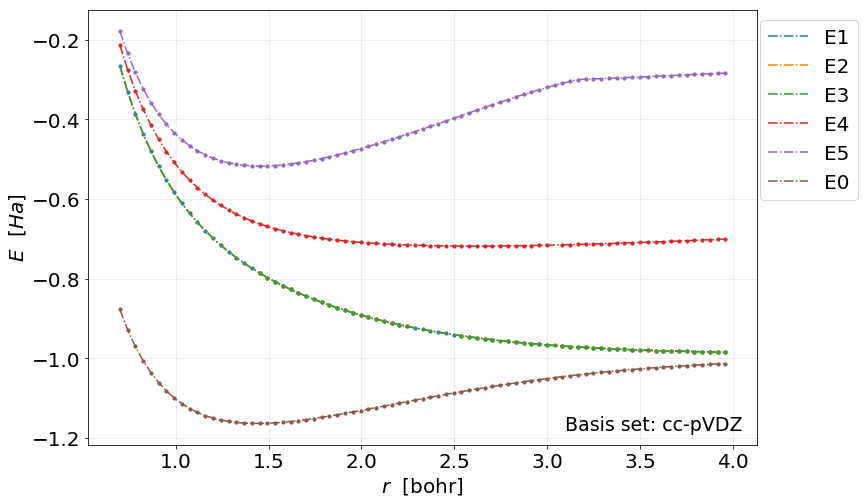

In [107]:
plotfunction_diatomic_exc([RJ,RJ],[EEOM,ECC],basis,eom_conv,[['E1','E2','E3','E4','E5'],'E0'])

In [17]:
# function [x, error, iter, flag] = gmres( A, x, b, M, restrt, max_it, tol )

# %  -- Iterative template routine --
# %     Univ. of Tennessee and Oak Ridge National Laboratory
# %     October 1, 1993
# %     Details of this algorithm are described in "Templates for the
# %     Solution of Linear Systems: Building Blocks for Iterative
# %     Methods", Barrett, Berry, Chan, Demmel, Donato, Dongarra,
# %     Eijkhout, Pozo, Romine, and van der Vorst, SIAM Publications,
# %     1993. (ftp netlib2.cs.utk.edu; cd linalg; get templates.ps).
# %
# % [x, error, iter, flag] = gmres( A, x, b, M, restrt, max_it, tol )
# %
# % gmres.m solves the linear system Ax=b
# % using the Generalized Minimal residual ( GMRESm ) method with restarts .
# %
# % input   A        REAL nonsymmetric positive definite matrix
# %         x        REAL initial guess vector
# %         b        REAL right hand side vector
# %         M        REAL preconditioner matrix
# %         restrt   INTEGER number of iterations between restarts
# %         max_it   INTEGER maximum number of iterations
# %         tol      REAL error tolerance
# %
# % output  x        REAL solution vector
# %         error    REAL error norm
# %         iter     INTEGER number of iterations performed
# %         flag     INTEGER: 0 = solution found to tolerance
# %                           1 = no convergence given max_it

#    iter = 0;                                         % initialization
#    flag = 0;

#    bnrm2 = norm( b );
#    if  ( bnrm2 == 0.0 ), bnrm2 = 1.0; end

#    r = M \ ( b-A*x );
#    error = norm( r ) / bnrm2;
#    if ( error < tol ) return, end

#    [n,n] = size(A);                                  % initialize workspace
#    m = restrt;
#    V(1:n,1:m+1) = zeros(n,m+1);
#    H(1:m+1,1:m) = zeros(m+1,m);
#    cs(1:m) = zeros(m,1);
#    sn(1:m) = zeros(m,1);
#    e1    = zeros(n,1);
#    e1(1) = 1.0;

#    for iter = 1:max_it,                              % begin iteration

#       r = M \ ( b-A*x );
#       V(:,1) = r / norm( r );
#       s = norm( r )*e1;
#       for i = 1:m,                                   % construct orthonormal
# 	 w = M \ (A*V(:,i));                         % basis using Gram-Schmidt
# 	 for k = 1:i,
# 	   H(k,i)= w'*V(:,k);
# 	   w = w - H(k,i)*V(:,k);
# 	 end
# 	 H(i+1,i) = norm( w );
# 	 V(:,i+1) = w / H(i+1,i);
# 	 for k = 1:i-1,                              % apply Givens rotation
#             temp     =  cs(k)*H(k,i) + sn(k)*H(k+1,i);
#             H(k+1,i) = -sn(k)*H(k,i) + cs(k)*H(k+1,i);
#             H(k,i)   = temp;
# 	 end
# 	 [cs(i),sn(i)] = rotmat( H(i,i), H(i+1,i) ); % form i-th rotation matrix
#          temp   = cs(i)*s(i);                        % approximate residual norm
#          s(i+1) = -sn(i)*s(i);
# 	 s(i)   = temp;
#          H(i,i) = cs(i)*H(i,i) + sn(i)*H(i+1,i);
#          H(i+1,i) = 0.0;
# 	 error  = abs(s(i+1)) / bnrm2;
# 	 if ( error <= tol ),                        % update approximation
# 	    y = H(1:i,1:i) \ s(1:i);                 % and exit
#             x = x + V(:,1:i)*y;
# 	    break;
# 	 end
#       end

#       if ( error <= tol ), break, end
#       y = H(1:m,1:m) \ s(1:m);
#       x = x + V(:,1:m)*y;                            % update approximation
#       r = M \ ( b-A*x )                              % compute residual
#       s(i+1) = norm(r);
#       error = s(i+1) / bnrm2;                        % check convergence
#       if ( error <= tol ), break, end;
#    end

#    if ( error > tol ) flag = 1; end;                 % converged

# % END of gmres.m

# function [ c, s ] = rotmat( a, b )

# %
# % Compute the Givens rotation matrix parameters for a and b.
# %
#    if ( b == 0.0 ),
#       c = 1.0;
#       s = 0.0;
#    elseif ( abs(b) > abs(a) ),
#       temp = a / b;
#       s = 1.0 / sqrt( 1.0 + temp^2 );
#       c = temp * s;
#    else
#       temp = b / a;
#       c = 1.0 / sqrt( 1.0 + temp^2 );
#       s = temp * c;
#    end